In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels 
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Time Series Generation

In [2]:
from numpy.random import seed
from numpy.random import randn


Generate a price time series using the equation: $$\Delta y_{t}-d=\phi \left( \Delta y_{t-1}-d\right) +\varepsilon _{t}+\theta \varepsilon _{t-1}$$

where t ranges 0 to 2000, y0 = y1 = 100, $$\phi= 0.6, d = 0.025,\theta = -0.4$$ e(t) is a sequence
of i.i.d Gaussian random variables with zero mean and unit variance. Divide the time
series into a training set and a test set, representing 70% and 30% of the data, respectively.

In [3]:
#Lagged stock prices tend to follow a random walk model i.e which implies that they are not predicatable or mean-reverting. If we think of
#Random Walk as an AR(1) model then the coefficient of p_t-1 is 1, which does not satisfy the weak stationarity condition of
#AR(1) model.A conventional approach to handle the unit root non-stationarity is by differencing. Thus a time series y_t is ARIMA (p,1,q)
#if the change series follows a stationary and invertible ARMA (p,q) model. price series are believed to be non-stationary
#but the lag return series is stationary

# Initialise parameters of the ARIMA (1,1,1) model 
seed(20139722) #Initialise the random number generator of your chosen programming package using a seed equal to your student number.
d=0.025 #constant term
phi=0.6 #coefficient of the AR term 
theta=-0.4 #coefficient of the MA term
var_eps=1 #variance of the innovation/white noise term 
N=2000

# Generate a price time series using the equation above
eps=np.random.randn(N)*var_eps
dy=np.nan * eps
y=np.nan * eps

#Simulate first differences then use cumsum to get prices

dy[0]=0
y[0]=100

for t in range(1,N):
    dy[t]=phi*(dy[t-1]-d)+d+eps[t]+theta*eps[t-1]
    y[t]=y[t-1]+dy[t]

In [4]:
# Divide the time series into a training set and a test set, representing 70% and 30% of the data, respectively.
train,test=y[:round(N*0.7)],y[round(N*0.7):]

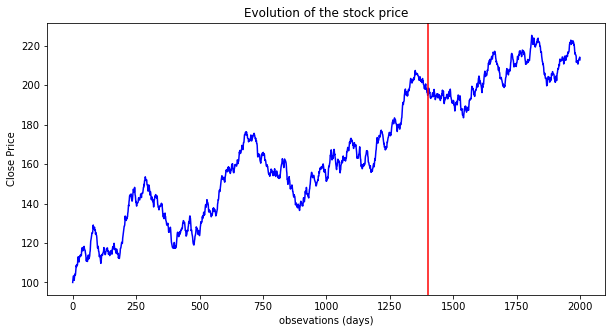

In [5]:
plt.figure(figsize = (10,5))
plt.plot(y,color='b')
plt.xlabel('obsevations (days)')
plt.ylabel('Close Price')
plt.axvline(x=round(N*0.7),color='r')
plt.ylabel('Close Price')
plt.title('Evolution of the stock price')
plt.savefig("Fig1_1.png")

## Strategy 1: A trend following strategy
* https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a
* https://pythonforfinance.net/2017/01/28/optimisation-of-moving-average-crossover-trading-strategy-in-python/
* The trend following strategy follows market winners needs to recognise when the markets change trend, e.g. computing moving averages, average true range, bands, and channels varying trading frequency typically lower b trade-off between risk of losing trades and exploitation of profitable trades.

In [6]:
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())

In [47]:
df_train=pd.DataFrame(train,columns=['Close Price']) #create a dataframe of the train data
df_test=pd.DataFrame(test,columns=['Close Price']) #create a dataframe of the train data
df_y=pd.DataFrame(y,columns=['Close Price'])

In [51]:
#https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a
#https://pythonforfinance.net/2017/01/28/optimisation-of-moving-average-crossover-trading-strategy-in-python/

# Initialising the strategy 
window1=20 #time window for the short term moving average
window2=50 #time window for the long term moving average

data=df_train

cumsum=[0]
ma=np.zeros(data.shape)
w=np.zeros(data.shape)
cash=np.zeros(data.shape)
cash[0]=10000
t=range(0,N)

def ma_strategy(data, window1,window2):
    # Create short-term and long-term ema columns
    data["short EMA"]=data["Close Price"].ewm(span=window1, adjust=False).mean()
    data["long EMA"]=data["Close Price"].ewm(span=window2, adjust=False).mean()

    # create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
    data["Signal"]=np.where(data["short EMA"]>data["long EMA"],1.0,0.0)

    #create a new column position which is the day to day difference of the signal columns
    data["Position"]=data["Signal"].diff()

    for i,x in enumerate(data["Close Price"][:-1],0):
        if data["Position"][i+1]==1:
            w[i+1]=cash[i]/x+w[i]
            cash[i+1]=0
        if data["Position"][i+1]==0:
            w[i+1]=w[i]
            cash[i+1]=cash[i]
        if data["Position"][i+1]==-1:
            w[i+1]=0
            cash[i+1]=w[i]*x+cash[i]

    strategy=[a*b for a,b in zip(w,data["Close Price"])]+cash
    data["strategy"]=strategy
    data["returns"]=np.log(data["strategy"]/data["strategy"].shift())
    data["cum returns strategy"]=np.cumsum(data["returns"])+1#Cumulative performance of log returns
    sharpe = annualised_sharpe(data["returns"])
    return (data["cum returns strategy"].iloc[-1], sharpe)
    return (data)



In [52]:

# for optimisation purposes, we can now use the “numpy.linspace()” function to create an array of 
#values that we can assign to represent the different values of short moving average window and long moving average windows 

window1 = np.linspace(5,25,20,dtype=int) #short-term ema window
window2 = np.linspace(30,60,20,dtype=int) #long-term ema window

#Now we have to initialise 2 numpy arrays that will hold the results of our various backtest iterations; 
#one array to hold the ending p&l and one array to hold the Sharpe ratio.
#We set them to be 2 dimensional with sizes/lengths equal to the length of each of our short and long moving average array values that we wish to iterate over.
results_pnl = pd.DataFrame(np.zeros((len(window1),len(window2))),columns=window2, index=window1)
results_sharpe = pd.DataFrame(np.zeros((len(window1),len(window2))),columns=window2, index=window1)

for i, shortma in enumerate(window1):
    for j, longma in enumerate(window2):
        pnl, sharpe = ma_strategy(df_train,shortma,longma)
        results_pnl.iloc[i,j] = pnl
        results_sharpe.iloc[i,j] = sharpe

In [53]:
results_pnl
results_sharpe
max_ret=results_pnl.max().max()
#results_pnl

In [54]:
# we now have two numpy arrays “results_pnl” and “results_sharpe” that hold the ending P&L data and the Sharpe ratio for each run through of the backtest (with respective combinations of long and short moving averages) respectively.
# Arrays are difficult to gain insight from in their raw format – so let’s visualise the results with a color plot, which should allow us to see where the combinations of moving average windows gave the best results – here are the results of the P&L array:
max_ret=results_pnl.max().max()
poz=results_pnl[results_pnl==max_ret].dropna(axis=1,how='all').dropna(how='all')

optimal_window1=poz.index.item()
optimal_window2=poz.columns.item()

print("optimal short term EMA length based on max returns is: " + str(optimal_window1))
print("optimal long term EMA length based on max returns is: " + str(optimal_window2))

optimal short term EMA length based on max returns is: 5
optimal long term EMA length based on max returns is: 30


In [55]:
results_pnl.shape

(20, 20)

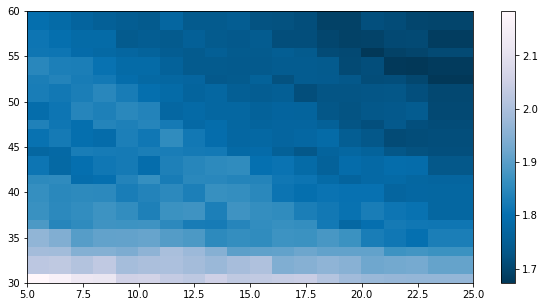

<Figure size 432x288 with 0 Axes>

In [56]:
plt.figure(figsize = (10,5))
plt.pcolor(window1,window2,results_pnl,cmap='PuBu_r')
plt.colorbar()
plt.show()
plt.savefig("Fig2_1.png")

In [57]:
max_ret,max_sharpe=ma_strategy(df_train,optimal_window1,optimal_window2)
df_train_opt=df_train

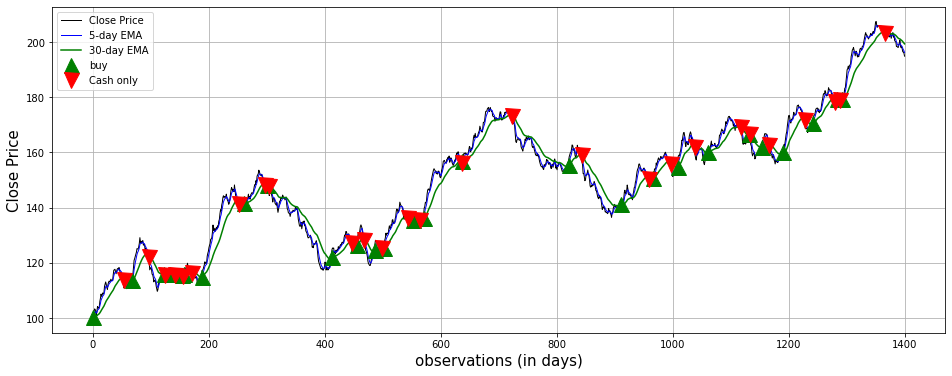

<Figure size 432x288 with 0 Axes>

In [58]:
plt.figure(figsize = (16,6))
# plot close price, short-term and long-term moving averages 
df_train['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price')  
df_train['short EMA'].plot(color = 'b', lw = 1, label = '5-day EMA') 
df_train['long EMA'].plot(color = 'g', lw = 1.5, label = '30-day EMA')
# plot ‘buy’ and 'hold' signals
plt.plot(df_train[df_train['Position'] == 1].index, 
         df_train['short EMA'][df_train['Position']  == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
plt.plot(df_train[df_train['Position'] == -1].index, 
          df_train['short EMA'][df_train['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'Cash only')
plt.ylabel('Close Price', fontsize = 15 )
plt.xlabel('observations (in days)', fontsize = 15 )
#plt.title('EMA Crossover Strategy', fontsize = 15)
plt.legend()
plt.grid()
plt.show()
plt.savefig("Fig2_3.png")

In [59]:
df_train["cum returns strategy"]=np.cumsum(df_train_opt["returns"])+1#Cumulative performance of log returns
df_train["cum returns buy and hold"]=np.cumsum(np.log(df_train_opt["Close Price"]/df_train_opt["Close Price"].shift()))+1 #Cumulative performance of log returns
print("Cumulative log returns of EMA crossover is: "+ str(df_train_opt["cum returns strategy"].iloc[-1]))
print("Cumulative log returns of buy and hold is: "+ str(df_train_opt["cum returns buy and hold"].iloc[-1]))

Cumulative log returns of EMA crossover is: 2.183127837751668
Cumulative log returns of buy and hold is: 1.66709138651777


## Performance in the test set

In [72]:
data=df_test
cumsum=[0]
ma=np.zeros(data.shape)
w=np.zeros(data.shape)
cash_test=np.zeros(data.shape)
cash_test[0]=cash[-1]
t=range(0,N)
window1=optimal_window1
window2=optimal_window2

In [73]:


# Create short-term and long-term ema columns
data["short EMA"]=data["Close Price"].ewm(span=window1, adjust=False).mean()
data["long EMA"]=data["Close Price"].ewm(span=window2, adjust=False).mean()

# create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
data["Signal"]=np.where(data["short EMA"]>data["long EMA"],1.0,0.0)

#create a new column position which is the day to day difference of the signal columns
data["Position"]=data["Signal"].diff()

for i,x in enumerate(data["Close Price"][:-1],0):
    if data["Position"][i+1]==1:
        w[i+1]=cash_test[i]/x+w[i]
        cash_test[i+1]=0
    if data["Position"][i+1]==0:
        w[i+1]=w[i]
        cash_test[i+1]=cash_test[i]
    if data["Position"][i+1]==-1:
        w[i+1]=0
        cash_test[i+1]=w[i]*x+cash_test[i]
        
strategy=[a*b for a,b in zip(w,data["Close Price"])]+cash_test
data["strategy"]=strategy
data["returns"]=np.log(data["strategy"]/data["strategy"].shift())
data["cum returns strategy"]=np.cumsum(data["returns"])+1#Cumulative performance of log returns
sharpe = annualised_sharpe(data["returns"])


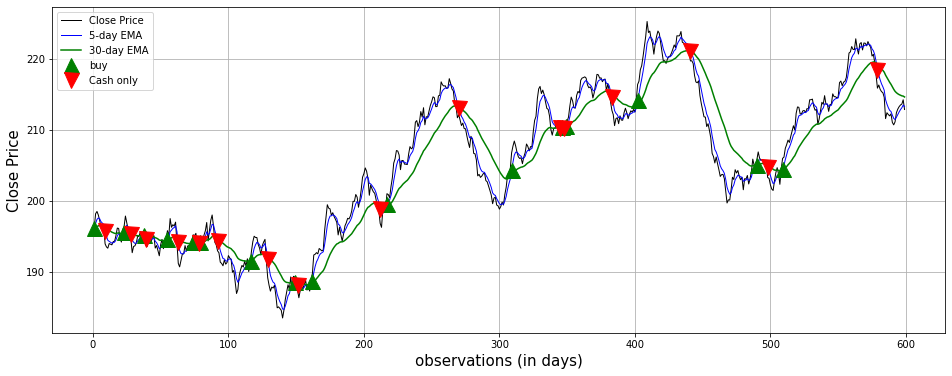

<Figure size 432x288 with 0 Axes>

In [74]:
plt.figure(figsize = (16,6))
# plot close price, short-term and long-term moving averages 
data['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price')  
data['short EMA'].plot(color = 'b', lw = 1, label = '5-day EMA') 
data['long EMA'].plot(color = 'g', lw = 1.5, label = '30-day EMA')
# plot ‘buy’ and 'hold' signals
plt.plot(data[data['Position'] == 1].index, 
         data['short EMA'][data['Position']  == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
plt.plot(data[data['Position'] == -1].index, 
          data['short EMA'][data['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'Cash only')
plt.ylabel('Close Price', fontsize = 15 )
plt.xlabel('observations (in days)', fontsize = 15 )
#plt.title('EMA Crossover Strategy', fontsize = 15)
plt.legend()
plt.grid()
plt.show()
plt.savefig("EMAtrading_test.png")

In [29]:
Cash0=10000
X0=Cash0/y[0]
buy_hold_value=np.zeros(y.shape)
buy_hold_value=X0*y

In [97]:
EMA_total_strategy=df_train_opt["strategy"].append(data["strategy"],ignore_index=True)


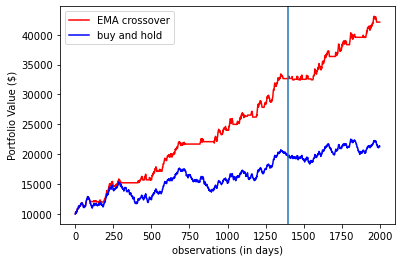

In [103]:
plt.plot(EMA_total_strategy,'r')
plt.plot(buy_hold_value,'b')
plt.xlabel('observations (in days)')
plt.ylabel('Portfolio Value ($)')
plt.legend(['EMA crossover','buy and hold'])
plt.axvline(x=len(df_train))
plt.savefig("EMA.png")

In [215]:
#https://blog.quantinsti.com/forecasting-stock-returns-using-arima-model/
#http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-paper'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        qq_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.qqplot(y,line="s",ax=qq_ax)
        qq_ax.set_title('QQ Plot')        

        plt.tight_layout()
    return 

In [107]:
df_train["log_ret"]=np.log(df_train["Close Price"]/df_train["Close Price"].shift())
log_ret=df_train["log_ret"].iloc[1:]
df_test["test_log_ret"]=np.log(df_test["Close Price"]/df_test["Close Price"].shift())
log_ret_test=df_test["test_log_ret"].iloc[1:]
Y=pd.DataFrame(y)
Y["total_ret"]=np.log(Y.iloc[:,0]/Y.iloc[:,0].shift())
total_ret=Y["total_ret"][1:]

# Strategy 2: ARIMA  (mean reversion)

* Here we show how the predictions of an autoregressive model (or any other statistical or machine learning model) can be used in a trading strategy. Let us consider a AR(p) and try to apply it to fit the price time series.
* using the Yule-Walker equations it is possible to estimate the values for the parameters f so that when measuring returns, though extremely hard in efficient markets, it is possible to obtain a prediction, phat

**then the trading strategy would be as follows:**

* if the expected price phat is larger than the present price p, buy a given amount of stocks,
* if the expected price phat is smaller than the present price pt,sell a given amount of stocks,

* https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis/
* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [108]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(log_ret, order=(i, j)).fit()
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -9942.35711 | order: (4, 3)


In [109]:
print('best estimated lag order for ARIMA model = {}'.format(best_order))

best estimated lag order for ARIMA model = (4, 3)


In [110]:
log_return=df_test["test_log_ret"].dropna()

fitted AR parameter 1.39, MA parameter -1.27


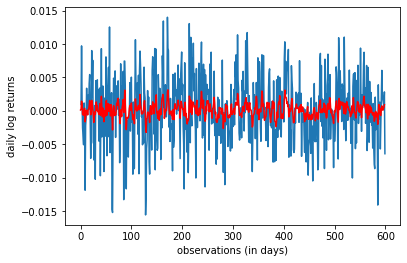

In [111]:
# Create a forecast of prices returns with 95%, 99% CI
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns


def fit_arima(log_returns):
        ar_lag_p = best_order[0]
        ma_lag_q = best_order[1]
        degree_of_differentiation_d = 0

        # create tuple : (p, d, q)
        order = (ar_lag_p, degree_of_differentiation_d, ma_lag_q)

        # create an ARIMA model object, passing in the values of the lret pandas series,
        # and the tuple containing the (p,d,q) order arguments
        arima_model = ARIMA(log_returns.values, order=order)
        arima_result = arima_model.fit()

        #TODO: from the result of calling ARIMA.fit(),
        # save and return the fitted values, autoregression parameters, and moving average parameters
        fittedvalues = arima_result.fittedvalues
        arparams = arima_result.arparams
        maparams = arima_result.maparams

        return fittedvalues,arparams,maparams
fittedvalues,arparams,maparams = fit_arima(log_return)
arima_pred = pd.Series(fittedvalues)
plt.plot(log_return)
plt.plot(arima_pred, color='r')
plt.xlabel("observations (in days)")
plt.ylabel("daily log returns")
print(f"fitted AR parameter {arparams[0]:.2f}, MA parameter {maparams[0]:.2f}")
plt.savefig("returnstest.png")

In [112]:
def get_plot(log_returns):
        ar_lag_p = best_order[0]
        ma_lag_q = best_order[1]
        degree_of_differentiation_d = 0

        # create tuple : (p, d, q)
        order = (ar_lag_p, degree_of_differentiation_d, ma_lag_q)

        # create an ARIMA model object, passing in the values of the lret pandas series,
        # and the tuple containing the (p,d,q) order arguments
        arima_model = ARIMA(log_returns.values, order=order)
        arima_result = arima_model.fit()

        #TODO: from the result of calling ARIMA.fit(),
        # save and return the fitted values, autoregression parameters, and moving average parameters
        fittedvalues = arima_result.fittedvalues
        arparams = arima_result.arparams
        maparams = arima_result.maparams

        return tsplot(arima_result.resid,lags=30)

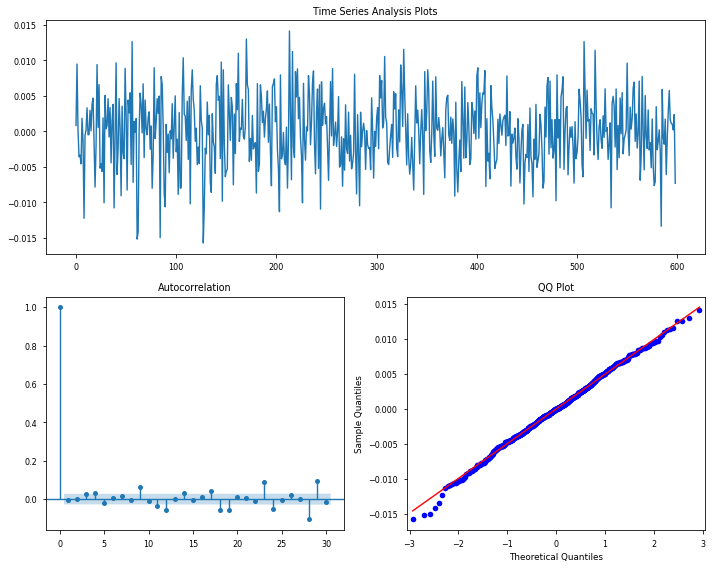

In [216]:
get_plot(log_return)

41    0.005033
dtype: float64
42    0.012229
dtype: float64
43    0.007724
dtype: float64
44    0.004043
dtype: float64
45    0.005062
dtype: float64
46    0.005741
dtype: float64
47   -0.000421
dtype: float64
48    0.000535
dtype: float64
49    0.005119
dtype: float64
50    0.001035
dtype: float64
51   -0.000912
dtype: float64
52    0.001825
dtype: float64
53   -0.00098
dtype: float64
54   -0.002622
dtype: float64
55    0.00067
dtype: float64
56    0.000717
dtype: float64
57   -0.013094
dtype: float64
58   -0.008067
dtype: float64
59   -0.011479
dtype: float64
60   -0.003643
dtype: float64
61    0.006245
dtype: float64
62    0.000667
dtype: float64
63    0.001791
dtype: float64
64   -0.006125
dtype: float64
65    0.009732
dtype: float64
66    0.005569
dtype: float64
67    0.002597
dtype: float64
68    0.003364
dtype: float64
69    0.003225
dtype: float64
70   -0.000427
dtype: float64
71    0.004201
dtype: float64
72    0.008912
dtype: float64
73    0.00006
dtype: float64
74    0.00565

309   -0.001851
dtype: float64
310   -0.001939
dtype: float64
311   -0.002214
dtype: float64
312    0.001147
dtype: float64
313   -0.00078
dtype: float64
314    0.000524
dtype: float64
315   -0.002419
dtype: float64
316   -0.000497
dtype: float64
317   -0.00091
dtype: float64
318    0.000837
dtype: float64
319   -0.003109
dtype: float64
320   -0.001434
dtype: float64
321    0.001323
dtype: float64
322    0.001471
dtype: float64
323    0.002837
dtype: float64
324    0.00006
dtype: float64
325    0.004996
dtype: float64
326   -0.000377
dtype: float64
327    0.002509
dtype: float64
328    0.003939
dtype: float64
329    0.000164
dtype: float64
330    0.000384
dtype: float64
331    0.001348
dtype: float64
332   -0.000436
dtype: float64
333    0.001127
dtype: float64
334    0.001131
dtype: float64
335   -0.001872
dtype: float64
336   -0.002481
dtype: float64
337   -0.001028
dtype: float64
338   -0.001778
dtype: float64
339   -0.000756
dtype: float64
340   -0.001604
dtype: float64
341   -0.00

575    0.001481
dtype: float64
576    0.001345
dtype: float64
577    0.005498
dtype: float64
578    0.005491
dtype: float64
579    0.00257
dtype: float64
580    0.001064
dtype: float64
581    0.000976
dtype: float64
582    0.002297
dtype: float64
583    0.002452
dtype: float64
584    0.003717
dtype: float64
585    0.004072
dtype: float64
586    0.002764
dtype: float64
587    0.003064
dtype: float64
588    0.003832
dtype: float64
589    0.002488
dtype: float64
590    0.000607
dtype: float64
591    0.000833
dtype: float64
592    0.000095
dtype: float64
593   -0.000529
dtype: float64
594    0.001531
dtype: float64
595   -0.00036
dtype: float64
596    0.000655
dtype: float64
597    0.001002
dtype: float64
598    0.000727
dtype: float64
599   -0.001713
dtype: float64
600   -0.002014
dtype: float64
601    0.000623
dtype: float64
602    0.004532
dtype: float64
603    0.002056
dtype: float64
604    0.00261
dtype: float64
605    0.003857
dtype: float64
606    0.00248
dtype: float64
607    0.001

841   -0.000168
dtype: float64
842   -0.000764
dtype: float64
843   -0.000784
dtype: float64
844   -0.005023
dtype: float64
845   -0.002772
dtype: float64
846   -0.005294
dtype: float64
847   -0.002313
dtype: float64
848   -0.002909
dtype: float64
849   -0.002167
dtype: float64
850   -0.000887
dtype: float64
851    0.000491
dtype: float64
852    0.001637
dtype: float64
853    0.001891
dtype: float64
854    0.000791
dtype: float64
855   -0.000759
dtype: float64
856    0.000481
dtype: float64
857   -0.003689
dtype: float64
858   -0.004235
dtype: float64
859   -0.00036
dtype: float64
860   -0.001049
dtype: float64
861   -0.001521
dtype: float64
862    0.002637
dtype: float64
863   -0.000759
dtype: float64
864   -0.000887
dtype: float64
865    0.003337
dtype: float64
866    0.000111
dtype: float64
867   -0.003353
dtype: float64
868   -0.002799
dtype: float64
869    0.000309
dtype: float64
870   -0.003508
dtype: float64
871   -0.002167
dtype: float64
872   -0.000291
dtype: float64
873   -0.

1103   -0.000387
dtype: float64
1104   -0.000457
dtype: float64
1105   -0.001747
dtype: float64
1106    0.000496
dtype: float64
1107   -0.001163
dtype: float64
1108   -0.001607
dtype: float64
1109    0.001503
dtype: float64
1110    0.000557
dtype: float64
1111    0.002537
dtype: float64
1112   -0.001881
dtype: float64
1113    0.000158
dtype: float64
1114    0.001228
dtype: float64
1115    0.000325
dtype: float64
1116    0.000785
dtype: float64
1117    0.000273
dtype: float64
1118   -0.000714
dtype: float64
1119   -0.000734
dtype: float64
1120   -0.002463
dtype: float64
1121   -0.004825
dtype: float64
1122   -0.002851
dtype: float64
1123    0.000776
dtype: float64
1124    0.000311
dtype: float64
1125    0.000133
dtype: float64
1126   -0.001343
dtype: float64
1127    0.000555
dtype: float64
1128    0.003214
dtype: float64
1129    0.000475
dtype: float64
1130    0.000604
dtype: float64
1131    0.00355
dtype: float64
1132    0.002933
dtype: float64
1133   -0.001899
dtype: float64
1134   -0

1360    0.00014
dtype: float64
1361   -0.000814
dtype: float64
1362   -0.000405
dtype: float64
1363    0.00115
dtype: float64
1364    0.000138
dtype: float64
1365   -0.002383
dtype: float64
1366   -0.001785
dtype: float64
1367    0.000695
dtype: float64
1368    0.000843
dtype: float64
1369    0.00028
dtype: float64
1370    0.00111
dtype: float64
1371   -0.001182
dtype: float64
1372   -0.000338
dtype: float64
1373    0.000748
dtype: float64
1374    0.000083
dtype: float64
1375   -0.000135
dtype: float64
1376    0.000047
dtype: float64
1377   -0.001103
dtype: float64
1378    0.00141
dtype: float64
1379    0.001202
dtype: float64
1380    0.000942
dtype: float64
1381   -0.001117
dtype: float64
1382    0.000945
dtype: float64
1383   -0.001595
dtype: float64
1384   -0.000877
dtype: float64
1385   -0.001376
dtype: float64
1386   -0.001856
dtype: float64
1387   -0.00052
dtype: float64
1388   -0.000367
dtype: float64
1389   -0.000106
dtype: float64
1390    0.00118
dtype: float64
1391    0.00106

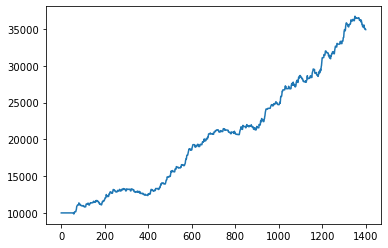

In [114]:
#TRADING: ARIMA
    
time_window = 40
cumsum = [0]
S=df_train["Close Price"]
arima_prediction = np.zeros(np.shape(S))

w = np.zeros(np.shape(S))
cash = np.zeros(np.shape(S))

cash[0] = 10000

for i, x in enumerate(S[:-1], 0):
    cumsum.append(cumsum[i] + x)
    arima_prediction[i] = x
    if i>=time_window:
        X = total_ret[0:i]
        train = X
        #print (train)
        # train ARIMA
        model = smt.ARMA(train, order=best_order)
        model_fit = model.fit(method='mle', trend='c')
        predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
        print (predictions)
        arima_prediction[i] =np.exp(predictions)*y[i-1]
        #print(arima_prediction[i])
  
    if arima_prediction[i] == x:
        w[i+1] = w[i]
        cash[i+1] = cash[i]
    
    if arima_prediction[i] < x: 
        w[i+1] = cash[i]/x  + w[i]
        cash[i+1] = 0
        
    if arima_prediction[i] > x:
        cash[i+1] = w[i]*x + cash[i]
        w[i+1] = 0


arima_strategy = [a*b for a,b in zip(w,S)]+ cash


#plt.plot(t, mr_strategy)
plt.plot(arima_strategy)
plt.show()

In [117]:
arima_strategy=pd.DataFrame(arima_strategy)
arima_strategy["returns"]=np.log(arima_strategy.iloc[:,0]/arima_strategy.iloc[:,0].shift())
arima_strategy["cum returns"]=arima_strategy["returns"].cumsum()+1
print("Cumulative log returns of ARIMA strategy is: "+ str(arima_strategy["cum returns"].iloc[-1]))
print("Cumulative log returns of buy and hold is: "+ str(df_train_opt["cum returns buy and hold"].iloc[-1]))
print("Annualised sharpe ARIMA: " + str(annualised_sharpe(arima_strategy["returns"])))
print("Annualised sharpe buy and hold: " + str(annualised_sharpe(df_train_opt["returns"])))

Cumulative log returns of ARIMA strategy is: 2.25021991813926
Cumulative log returns of buy and hold is: 1.66709138651777
Annualised sharpe ARIMA: 2.916495007133527
Annualised sharpe buy and hold: 2.463615804664129


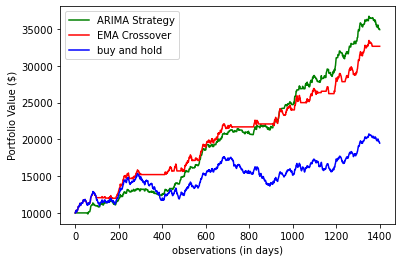

In [118]:
plt.plot(arima_strategy.iloc[:,0],'g')
plt.plot(df_train_opt["strategy"],'r')
plt.plot(buy_hold_value[:len(df_train_opt["strategy"])],'b')
plt.xlabel('observations (in days)')
plt.ylabel('Portfolio Value ($)')
plt.legend(['ARIMA Strategy',"EMA Crossover",'buy and hold'])
plt.savefig("arima.png")

## ARIMA-test

In [123]:
time_window = 30
cumsum = [0]
S=df_test["Close Price"]
arimatest_prediction = np.zeros(np.shape(S))
w = np.zeros(np.shape(S))
cash_test = np.zeros(np.shape(S))

cash_test[0] = cash[-1]

31   -0.00039
dtype: float64
32    0.003138
dtype: float64
33   -0.000414
dtype: float64
34    0.001038
dtype: float64
35   -0.00137
dtype: float64
36   -0.000695
dtype: float64
37   -0.002172
dtype: float64
38   -0.002625
dtype: float64
39   -0.000439
dtype: float64
40   -0.002247
dtype: float64
41    0.000554
dtype: float64
42    0.000334
dtype: float64
43    0.000469
dtype: float64
44   -0.00186
dtype: float64
45   -0.001747
dtype: float64
46   -0.000286
dtype: float64
47    0.000517
dtype: float64
48   -0.000378
dtype: float64
49    0.000976
dtype: float64
50    0.001795
dtype: float64
51    0.001577
dtype: float64
52   -0.003768
dtype: float64
53    0.001638
dtype: float64
54    0.001746
dtype: float64
55   -0.005068
dtype: float64
56   -0.001759
dtype: float64
57   -0.003272
dtype: float64
58   -0.005736
dtype: float64
59   -0.00623
dtype: float64
60    0.001099
dtype: float64
61   -0.002726
dtype: float64
62   -0.004299
dtype: float64
63    0.002661
dtype: float64
64    0.001731

299    0.000823
dtype: float64
300    0.000119
dtype: float64
301   -0.000193
dtype: float64
302    0.000561
dtype: float64
303    0.000756
dtype: float64
304   -0.000256
dtype: float64
305   -0.000592
dtype: float64
306    0.001931
dtype: float64
307    0.001972
dtype: float64
308    0.001094
dtype: float64
309   -0.000748
dtype: float64
310    0.001811
dtype: float64
311    0.000915
dtype: float64
312    0.000655
dtype: float64
313    0.000192
dtype: float64
314   -0.00042
dtype: float64
315   -0.000449
dtype: float64
316   -0.000089
dtype: float64
317   -0.000095
dtype: float64
318   -0.000189
dtype: float64
319    0.000354
dtype: float64
320    0.000612
dtype: float64
321    0.000733
dtype: float64
322   -0.000294
dtype: float64
323   -0.000935
dtype: float64
324    0.000546
dtype: float64
325   -0.00032
dtype: float64
326    0.001514
dtype: float64
327    0.001806
dtype: float64
328    0.000313
dtype: float64
329    0.001607
dtype: float64
330    0.001268
dtype: float64
331    0.0

564    0.001631
dtype: float64
565   -0.000065
dtype: float64
566   -0.001084
dtype: float64
567    0.001522
dtype: float64
568    0.001117
dtype: float64
569   -0.000562
dtype: float64
570    0.000908
dtype: float64
571   -0.000354
dtype: float64
572    0.000576
dtype: float64
573   -0.000084
dtype: float64
574   -0.00011
dtype: float64
575   -0.000159
dtype: float64
576   -0.000485
dtype: float64
577    0.000512
dtype: float64
578   -0.000262
dtype: float64
579   -0.001036
dtype: float64
580   -0.001431
dtype: float64
581   -0.000367
dtype: float64
582   -0.000647
dtype: float64
583   -0.000625
dtype: float64
584   -0.000092
dtype: float64
585   -0.00061
dtype: float64
586   -0.002269
dtype: float64
587   -0.000366
dtype: float64
588    0.000169
dtype: float64
589   -0.001076
dtype: float64
590    0.000669
dtype: float64
591   -0.001167
dtype: float64
592   -0.00071
dtype: float64
593    0.000615
dtype: float64
594    0.000262
dtype: float64
595    0.001528
dtype: float64
596   -0.00

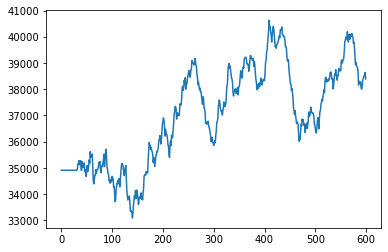

In [124]:
for i, x in enumerate(S[:-1], 0):
    cumsum.append(cumsum[i] + x)
    arimatest_prediction[i] = x
    if i>=time_window:
        X = log_ret_test[0:i]
        test = X
        #print (train)
        # train ARIMA
        model = smt.ARMA(test, order=best_order)
        model_fit = model.fit(method='mle', trend='c')
        predictions = model_fit.predict(start=len(test), end=len(test), dynamic=False)
        print (predictions)
        arimatest_prediction[i] =np.exp(predictions)*y[i-1]
        #print(arima_prediction[i])
  
    if arimatest_prediction[i] == x:
        w[i+1] = w[i]
        cash_test[i+1] = cash_test[i]
    
    if arimatest_prediction[i] < x: 
        w[i+1] = cash_test[i]/x  + w[i]
        cash_test[i+1] = 0
        
    if arimatest_prediction[i] > x:
        cash_test[i+1] = w[i]*x + cash_test[i]
        w[i+1] = 0


arimatest_strategy = [a*b for a,b in zip(w,S)]+ cash_test


#plt.plot(t, mr_strategy)
plt.plot(arimatest_strategy)
plt.show()

In [132]:
arimatest_strategy=pd.DataFrame(arimatest_strategy)

0      34911.106316
1      34911.106316
2      34911.106316
3      34911.106316
4      34911.106316
           ...     
595    38464.563293
596    38507.812301
597    38530.460990
598    38639.896668
599    38393.147854
Name: 0, Length: 600, dtype: float64

In [135]:
arima_total_strategy=arima_strategy.iloc[:,0].append(arimatest_strategy.iloc[:,0],ignore_index=True)

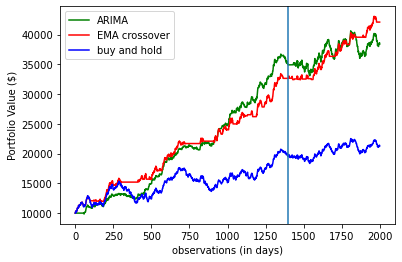

In [138]:
plt.plot(arima_total_strategy,'g')
plt.plot(EMA_total_strategy,'r')
plt.plot(buy_hold_value,'b')
plt.xlabel('observations (in days)')
plt.ylabel('Portfolio Value ($)')
plt.legend(['ARIMA','EMA crossover','buy and hold'])
plt.axvline(x=len(df_train))
plt.savefig("arima.png")

# Strategy 3: ARIMA- GARCH
https://robotwealth.com/fitting-time-series-models-to-the-forex-market-are-arimagarch-predictions-profitable/
https://www.kaggle.com/akm5160/arma-1-1-garch-1-1
https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/


In [139]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    pq_rng = range(5) # [0,1,2,3,4]

    #d_rng = range(2) # [0,1]
    for i in pq_rng:
        #for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARMA(TS, order=(i,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i,j)
                    best_mdl = tmp_mdl
            except: continue
    print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl
TS = log_ret
res_tup = _get_best_model(TS)

aic: -9942.36 | order: (4, 3)


In [140]:
order = res_tup[1]
model = res_tup[2]

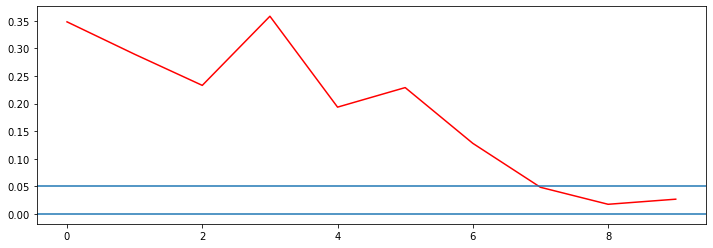

In [141]:
#ljung-box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
#ar1,ar2,ar3,ar4=acorr_ljungbox(data2.ma**2, lags=10, boxpierce=True)
ar1,ar2,ar3,ar4=acorr_ljungbox(model.resid**2, lags=10, boxpierce=True)
#2nd array list is p values from ljung-box test
#4th array list is p values from box-pierce test

plt.subplots(figsize=(12,4))
plt.plot(ar2, color='red')
plt.axhline(y=0)
plt.axhline(y=0.05)

#our intention is to check for autocorrelation, the part our mean model in ARMA was not able to capture.
#H0- No autocorrelation in the resids, no arch effect
#H1-autocorrelation in the residuals is present, Arch effect, model needs arch correction
#as we can see lag-1 and later lags are significant, so arch effect is present. p<alpha, reject the null hypothesis

#now we will be moving to arch correction via garch and we will try to model volatility.

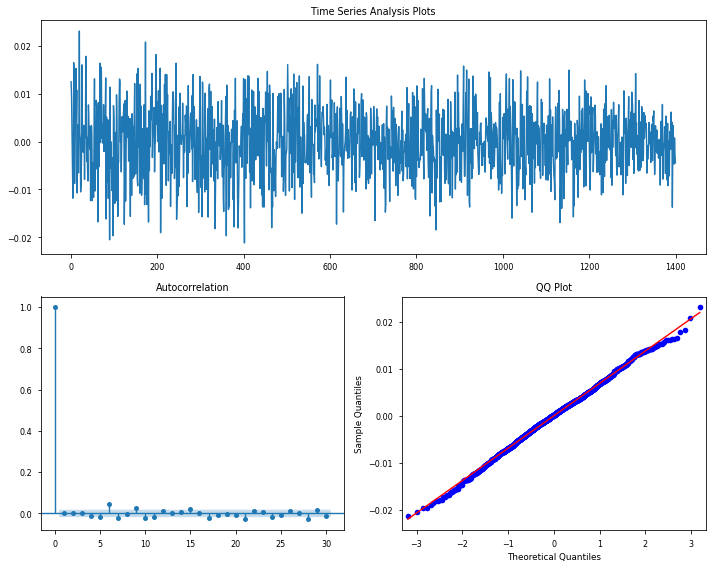

In [142]:
#now we will be moving to arch correction via garch and we will try to model volatility.
#https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755

tsplot(model.resid, lags=30)


In [143]:
#!pip install arch

from arch import arch_model
#https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html
#https://anstochibamu.github.io/wp-content/uploads/2019/11/GARCH-in-python.pdf
#https://iae-analyst.medium.com/combining-arima-garch-to-predict-stock-price-market-fbbf518f896b#:~:text=The%20ARIMA%20final%20model%20is,value%2C%20the%20stock%20is%20longed.

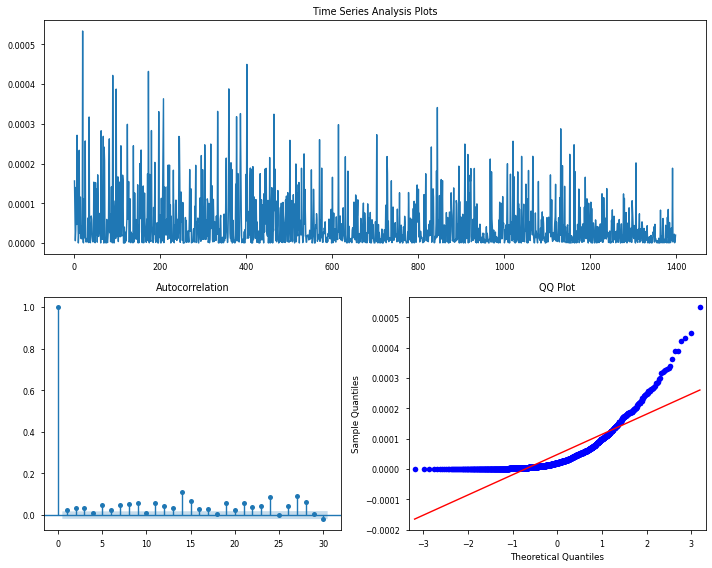

In [144]:
#We find the residuals look like white noise. Let’s look at the square of residuals
#We can see clear evidence of autocorrelation in squared residuals. Let’s fit a GARCH model and see how it does.
tsplot(model.resid**2, lags=30)

In [145]:

p_ = order[0]
#o_ = order[1]
q_ = order[1]

am = arch_model(model.resid, p=p_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                5009.03
Distribution:      Standardized Student's t   AIC:                          -9998.07
Method:                  Maximum Likelihood   BIC:                          -9945.63
                                              No. Observations:                 1399
Date:                      Tue, Mar 16 2021   Df Residuals:                     1398
Time:                              17:15:50   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

**Strategy Overview**
Let’s try to create a simple strategy using our knowledge so far about ARIMA and GARCH models. The idea of this strategy is as below:
* Fit an ARIMA and GARCH model everyday on log returns for previous T days
* Use the combined model to make a prediction for the next day’s return
* If the prediction is positive, buy the stock and if negative liquidate the position on the stock
* If the prediction is the same as the previous day then do nothing

In [147]:
time_window = 30
cumsum = [0]
S=df_train["Close Price"]
arima2_prediction = np.zeros(np.shape(S))
#p_, q_ = best_order
w = np.zeros(np.shape(S))
cash = np.zeros(np.shape(S))

cash[0] = 10000



In [148]:
for i, x in enumerate(S[:-1], 0):
    arima2_prediction[i] = x
    try:
        if i>=time_window:
            X = total_ret[0:i]
            TS = X
            res_tup = _get_best_model(TS)
            order = res_tup[1]
            model = res_tup[2]

            #now that we have our ARIMA fit, we feed this to GARCH model
            p_ = max(order[0],1)
            #o_ = order[1]
            q_ = order[1]

            #print (train)
            # train ARIMA
            am = arch_model(model.resid, p=p_,q=q_, dist='StudentsT')
            res = am.fit(update_freq=5, disp='off')
            # Generate a forecast of next day return using our fitted model
            out = res.forecast(horizon=1, start=None, align='origin')
            #print(out)

            predictions=out.mean['h.1'].iloc[-1]    
            arima2_prediction[i] =np.exp(predictions)*y[i-1]
            print(arima2_prediction[i])
    except:
        pass


aic: -200.15 | order: (0, 3)
113.09286902137707
aic: -208.14 | order: (0, 3)
113.4857861677663
aic: -213.00 | order: (0, 3)
114.10254151917161
aic: -220.95 | order: (0, 3)
113.59784728504262
aic: -226.81 | order: (0, 3)
113.6610921514047
aic: -233.41 | order: (0, 3)
113.60675113907662
aic: -241.33 | order: (0, 3)
115.68973173722695
aic: -248.93 | order: (0, 3)
117.35475252599471
aic: -256.80 | order: (0, 3)
117.54645319708305
aic: -262.54 | order: (2, 1)
117.63861788511616
aic: -269.27 | order: (2, 1)
116.87546202265483
aic: -277.04 | order: (2, 1)
116.0161379198043
aic: -284.42 | order: (2, 1)
117.04193583605571
aic: -291.98 | order: (2, 1)
117.73282673182977
aic: -299.30 | order: (2, 1)
149.45009322593972
aic: -307.33 | order: (2, 1)
117.61675898659095


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -311.00 | order: (2, 1)
118.29039853946932
aic: -317.73 | order: (2, 1)
117.27739433026106
aic: -325.00 | order: (2, 1)
116.51665045432752
aic: -331.67 | order: (3, 0)
116.42867520573176
aic: -335.65 | order: (2, 0)
108.59182828514062
aic: -343.32 | order: (2, 0)
664.9405076679221


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -348.47 | order: (2, 2)
114.50442705935124
aic: -351.99 | order: (0, 1)
113.0624861509689
aic: -359.76 | order: (0, 1)
111.14871144413284
aic: -366.13 | order: (2, 0)
110.7534568705175
aic: -370.95 | order: (0, 1)
112.12419454393653
aic: -378.36 | order: (0, 1)
111.30530840888686
aic: -385.60 | order: (2, 2)
111.48702961516949
aic: -390.61 | order: (0, 1)
110.60206334834695
aic: -399.84 | order: (2, 2)
111.44139348512647
aic: -407.74 | order: (2, 2)
112.67461868453822
aic: -415.68 | order: (2, 2)
113.7579182206246
aic: -420.72 | order: (2, 2)
113.86690835252277
aic: -427.16 | order: (2, 2)
111.92627762143351
aic: -433.91 | order: (2, 2)
112.62568074881256
aic: -441.71 | order: (2, 2)
112.41119202176415
aic: -448.73 | order: (2, 2)
112.8345698277663
aic: -451.40 | order: (2, 2)
113.4814373725632
aic: -459.13 | order: (2, 2)
115.30959825756098
aic: -464.51 | order: (2, 2)
115.93579353477301
aic: -467.21 | order: (2, 2)
118.4375650708754
aic: -474.86 | order: (2, 2)
120.8652193472414

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -511.87 | order: (2, 2)
125.11173641569997
aic: -519.37 | order: (2, 2)
125.0097438687456
aic: -526.31 | order: (2, 2)
124.9519934032765
aic: -533.41 | order: (2, 2)
125.80851514261718
aic: -540.28 | order: (2, 2)
127.06909662784359
aic: -541.99 | order: (2, 2)
129.11369341100075
aic: -549.20 | order: (2, 2)
127.37716422281859


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -556.38 | order: (2, 2)
1491.8066322345792


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -564.11 | order: (2, 2)
127.07860486873584
aic: -571.87 | order: (2, 2)
127.47517637156837
aic: -576.68 | order: (2, 2)
128.02729177474285
aic: -583.99 | order: (2, 2)
126.39239796910742


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -591.78 | order: (2, 2)
126.5025834502708
aic: -590.55 | order: (0, 1)
126.76622477648735
aic: -598.13 | order: (2, 2)
124.46444752168527


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -605.52 | order: (2, 2)
125.28622790999168


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -612.55 | order: (2, 2)
124.34784263314701
aic: -619.67 | order: (2, 2)
124.16546987467227
aic: -626.85 | order: (2, 2)
123.91391943129562
aic: -632.67 | order: (2, 2)
122.82334355515287
aic: -637.71 | order: (2, 2)
121.13828430653912
aic: -638.97 | order: (1, 0)
3.545750369258776e+17
aic: -647.05 | order: (3, 3)
117.47884834719179
aic: -654.11 | order: (3, 3)
117.89875438431376
aic: -661.65 | order: (3, 3)
118.32655976155061
aic: -664.74 | order: (2, 2)
117.69767270977792
aic: -672.40 | order: (2, 2)
115.87341389841141
aic: -679.04 | order: (2, 2)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -684.36 | order: (1, 0)
115.16013902230605
aic: -691.27 | order: (1, 0)
121.7730732390398
aic: -698.85 | order: (1, 0)
113.53429350476603
aic: -706.01 | order: (1, 0)
130.45778251380608
aic: -711.95 | order: (4, 2)
113.24446949136808
aic: -719.52 | order: (4, 2)
111.5752627439885
aic: -726.75 | order: (4, 2)
110.63200729816326
aic: -733.58 | order: (4, 2)
109.66583199273931
aic: -738.66 | order: (4, 2)
110.22829327006332
aic: -744.12 | order: (1, 0)
138.9168955479247
aic: -751.63 | order: (1, 0)
113.25712230808381
aic: -759.21 | order: (1, 0)
114.33447678345824
aic: -766.44 | order: (4, 2)
114.27564492670083
aic: -774.05 | order: (4, 2)
113.73874619079001
aic: -781.56 | order: (4, 2)
114.00317056338943
aic: -789.18 | order: (4, 2)
114.81047484761027
aic: -796.85 | order: (4, 2)
115.13662670825451
aic: -804.49 | order: (4, 2)
115.42776642764122
aic: -811.73 | order: (4, 2)
inf
aic: -814.38 | order: (4, 2)
117.6770036480974
aic: -821.01 | order: (4, 2)
116.17748809002738
aic: -828.4

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1492.88 | order: (4, 3)
141.8032809355768
aic: -1500.58 | order: (4, 3)
143.58355703122652
aic: -1499.55 | order: (1, 1)
144.28219157657125
aic: -1509.53 | order: (3, 2)
143.70390096025508
aic: -1514.45 | order: (1, 1)
144.03997728829478
aic: -1522.13 | order: (1, 1)
143.66028013363274
aic: -1529.62 | order: (1, 1)
143.99900017856731
aic: -1534.74 | order: (1, 1)
144.85536631354512
aic: -1543.17 | order: (3, 2)
143.24464762273658
aic: -1559.03 | order: (3, 3)
142.65035334433236
aic: -1556.62 | order: (1, 1)
142.20175224829208
aic: -1564.18 | order: (1, 1)
141.1755450861679
aic: -1570.51 | order: (1, 1)
1.0629457869032717e+69
aic: -1576.78 | order: (1, 1)
142.91475178347017
aic: -1583.58 | order: (1, 0)
144.57218047022516
aic: -1591.12 | order: (1, 0)
146.2129101921113
aic: -1606.65 | order: (3, 3)
147.2539709169507
aic: -1605.65 | order: (1, 0)
aic: -1616.26 | order: (4, 4)
146.1226984558975
aic: -1624.02 | order: (4, 4)
146.49331788600963
aic: -1633.36 | order: (3, 3)
145.790579

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2605.38 | order: (1, 1)
127.97985359644676
aic: -2608.01 | order: (2, 1)
126.76659275352071
aic: -2618.97 | order: (4, 3)
124.3598536307418
aic: -2625.17 | order: (4, 3)
122.11878462037626
aic: -2632.96 | order: (4, 3)
120.48481722736481
aic: -2640.74 | order: (4, 3)
119.8242032467762
aic: -2648.54 | order: (4, 3)
119.09808738449915
aic: -2649.96 | order: (2, 1)
118.49855622784118
aic: -2664.00 | order: (4, 3)
117.82591652480428
aic: -2665.09 | order: (2, 1)
117.68214412507743
aic: -2673.49 | order: (4, 4)
118.01167893717135
aic: -2686.89 | order: (4, 3)
117.43176216021303
aic: -2694.22 | order: (4, 3)
117.29647196645236
aic: -2701.82 | order: (4, 3)
117.87572986172148
aic: -2706.20 | order: (4, 3)
118.42620378932907
aic: -2711.10 | order: (4, 4)
120.25660968753051
aic: -2707.93 | order: (2, 1)
119.84133062125167
aic: -2713.47 | order: (2, 1)
117.36777138498832
aic: -2721.44 | order: (4, 4)
118.4000224192077
aic: -2735.18 | order: (4, 3)
118.15980996913625
aic: -2742.75 | order: 

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3039.00 | order: (1, 1)
124.0221113677975
aic: -3045.52 | order: (4, 4)
124.52306028276115
aic: -3052.74 | order: (1, 1)
125.923459212371
aic: -3060.15 | order: (1, 1)
126.32459763057732
aic: -3067.92 | order: (1, 1)
125.94960425676734
aic: -3072.59 | order: (1, 1)
126.12791493186509
aic: -3080.35 | order: (1, 1)
128.0729081146359
aic: -3086.59 | order: (1, 1)
128.60514600606066
aic: -3094.50 | order: (4, 4)
130.27178608038847
aic: -3103.80 | order: (4, 2)
130.90049133086396
aic: -3106.44 | order: (1, 1)
129.9131040269042
aic: -3112.65 | order: (1, 1)
131.45261032613703
aic: -3120.42 | order: (1, 1)
133.15331926102897
aic: -3127.37 | order: (1, 1)
133.73003866817675
aic: -3134.34 | order: (1, 1)
133.17190133748554
aic: -3137.01 | order: (1, 1)
132.3956395822703
aic: -3147.66 | order: (4, 2)
129.9719625623898
aic: -3152.35 | order: (4, 2)
128.40765132268513
aic: -3155.18 | order: (1, 1)
126.2005985364913
aic: -3162.84 | order: (1, 1)
126.72698180556034
aic: -3169.18 | order: (1, 1

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3284.40 | order: (1, 1)
125.0127058609264
aic: -3292.72 | order: (4, 4)
126.62545026227647
aic: -3297.98 | order: (1, 1)
128.17331009478147
aic: -3305.68 | order: (1, 1)
127.74005898742418
aic: -3312.69 | order: (1, 1)
127.70257760609594
aic: -3324.32 | order: (4, 2)
126.94983042583257
aic: -3326.65 | order: (1, 1)
127.07856629950997
aic: -3335.48 | order: (4, 4)
125.80698286268651
aic: -3339.43 | order: (1, 1)
158.62119998507114
aic: -3346.54 | order: (1, 1)
125.4141244990774
aic: -3355.87 | order: (4, 4)
126.26381477754128
aic: -3360.05 | order: (1, 1)
126.34229202540237
aic: -3367.65 | order: (1, 1)
125.00573875476792
aic: -3375.35 | order: (1, 1)
125.96424601105663


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3383.13 | order: (1, 1)
inf
aic: -3389.99 | order: (1, 1)
123.7318710046551
aic: -3394.11 | order: (1, 1)
124.5901948779379
aic: -3401.06 | order: (1, 1)
126.67865432382973
aic: -3408.78 | order: (1, 1)
128.1354800538919
aic: -3415.17 | order: (1, 1)
128.96357103315103
aic: -3421.43 | order: (1, 1)
130.69245486042198
aic: -3428.94 | order: (1, 1)
129.99512696077522
aic: -3436.62 | order: (1, 1)
0.0001834645614640747
aic: -3445.86 | order: (4, 4)
130.6919046361172
aic: -3457.68 | order: (4, 3)
130.54137874040853
aic: -3464.99 | order: (4, 3)
132.1396768023859
aic: -3463.33 | order: (1, 1)
133.3972331453189
aic: -3471.10 | order: (1, 1)
132.47688220479165
aic: -3477.34 | order: (1, 1)
132.44037945959616
aic: -3484.72 | order: (1, 1)
133.84429762273064
aic: -3489.55 | order: (1, 1)
133.4801317008836
aic: -3505.47 | order: (4, 3)
135.4914109146623
aic: -3502.43 | order: (1, 1)
135.60668406019386
aic: -3509.84 | order: (1, 1)
134.1329766506367
aic: -3517.48 | order: (1, 1)
134.6904434

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3558.24 | order: (1, 1)
139.07296709126052
aic: -3565.48 | order: (1, 1)
138.14286844974794
aic: -3580.75 | order: (4, 3)
138.91729495080907
aic: -3577.78 | order: (4, 3)
139.67163098035758
aic: -3584.20 | order: (1, 1)
141.95669360855976
aic: -3591.41 | order: (1, 1)
141.2901606439485
aic: -3599.18 | order: (1, 1)
140.62813987594427
aic: -3608.42 | order: (4, 4)
140.59609348865055
aic: -3614.53 | order: (4, 3)
23706.832411253377


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3618.79 | order: (1, 1)
139.5615662764885
aic: -3625.56 | order: (1, 1)
137.39060851795145
aic: -3631.55 | order: (1, 1)
135.82077518031568
aic: -3638.51 | order: (1, 1)
136.80176677576875
aic: -3646.00 | order: (4, 3)
135.75565616699237
aic: -3653.79 | order: (4, 3)
136.23029256058643
aic: -3661.56 | order: (4, 3)
136.3723273206187
aic: -3668.94 | order: (1, 1)
136.45891186452843
aic: -3676.56 | order: (1, 1)
135.93250138845067
aic: -3684.30 | order: (4, 3)
135.42505833528168
aic: -3691.76 | order: (4, 3)
134.8065652157936
aic: -3699.22 | order: (4, 3)
133.99188655877742
aic: -3706.73 | order: (4, 3)
133.27409118688146
aic: -3713.71 | order: (1, 1)
133.58595398148398
aic: -3721.23 | order: (1, 1)
aic: -3728.96 | order: (1, 1)
134.09102316905236
aic: -3736.39 | order: (1, 1)
134.40130583517666
aic: -3741.14 | order: (1, 1)
135.16286304036316
aic: -3748.54 | order: (1, 1)
137.28587446315623


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3756.33 | order: (1, 1)
137.17860954400186
aic: -3764.09 | order: (1, 1)
137.42277540437055
aic: -3771.48 | order: (1, 1)
0.0
aic: -3777.51 | order: (1, 1)
137.35540884474685
aic: -3783.94 | order: (1, 1)
135.9244765087606
aic: -3791.73 | order: (1, 1)
136.9772676416936
aic: -3799.48 | order: (1, 1)
0.0044938613321107235
aic: -3807.26 | order: (1, 1)
136.92619773180158
aic: -3814.51 | order: (1, 1)
136.8142342954989
aic: -3821.85 | order: (1, 1)
136.01972071050886
aic: -3828.39 | order: (1, 1)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3835.52 | order: (1, 1)
133.73643642464802
aic: -3843.25 | order: (1, 1)
134.26548340377022
aic: -3850.76 | order: (1, 1)
134.52088428535728
aic: -3858.36 | order: (1, 1)
135.156717789753
aic: -3865.94 | order: (1, 1)
132.7649072977256
aic: -3873.66 | order: (1, 1)
136.58262797045185
aic: -3877.31 | order: (1, 1)
137.2068332335314
aic: -3885.11 | order: (1, 1)
139.77638326731253
aic: -3892.09 | order: (1, 1)
140.32923856374592
aic: -3899.54 | order: (1, 1)
141.84339951311281
aic: -3907.23 | order: (1, 1)
141.7347838499343
aic: -3911.88 | order: (1, 1)
142.4225142979009
aic: -3919.16 | order: (1, 1)
144.79452655695744
aic: -3926.92 | order: (1, 1)
146.30770895766886
aic: -3934.57 | order: (1, 1)
146.22762498568642
aic: -3941.82 | order: (1, 1)
146.70981231533645
aic: -3949.14 | order: (1, 1)
146.08187814833022
aic: -3956.13 | order: (1, 1)
148.95978563323453
aic: -3963.59 | order: (1, 1)
148.23596210693464
aic: -3970.91 | order: (1, 1)
149.3457166093397
aic: -3978.55 | order: (1, 

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4061.13 | order: (1, 1)
aic: -4068.63 | order: (1, 1)
153.25785428555773
aic: -4074.78 | order: (1, 1)
152570439.09591666
aic: -4082.58 | order: (1, 1)
151.24157631633054
aic: -4090.16 | order: (1, 1)
150.8074818960351
aic: -4094.80 | order: (1, 1)
151.22836382285416
aic: -4102.61 | order: (1, 1)
153.41607540486115
aic: -4110.12 | order: (1, 1)
2.0850902074495034e-22
aic: -4117.10 | order: (1, 1)
155.19225241859658
aic: -4124.80 | order: (1, 1)
0.0
aic: -4132.60 | order: (1, 1)
156.96871482936223
aic: -4139.80 | order: (1, 1)
157.08735175728924
aic: -4147.63 | order: (1, 1)
0.0
aic: -4155.39 | order: (1, 1)
156.36984016456915
aic: -4161.92 | order: (1, 1)
156.0772572388369
aic: -4169.69 | order: (1, 1)
157.49604825946312
aic: -4177.37 | order: (1, 1)
157.48426038707223
aic: -4184.88 | order: (1, 1)
158.18103957199423
aic: -4192.25 | order: (1, 1)
157.7407488823622
aic: -4196.01 | order: (1, 1)
158.68267173349037
aic: -4209.73 | order: (4, 3)
156.4281642839478
aic: -4210.53 | orde

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4218.05 | order: (1, 1)
158.0477955531096
aic: -4224.78 | order: (1, 1)
157.5932315635143
aic: -4232.52 | order: (1, 1)
156.3441131606149
aic: -4240.26 | order: (1, 1)
155.79217126128876
aic: -4247.92 | order: (1, 1)
155.24340062500136
aic: -4255.13 | order: (1, 1)
155.61585246433162
aic: -4262.88 | order: (1, 1)
156.63089661790883
aic: -4270.60 | order: (1, 1)
157.2759823443816
aic: -4277.10 | order: (1, 1)
155.90214210083556


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4284.71 | order: (1, 1)
158.74418890753958
aic: -4292.10 | order: (1, 1)
159.78051432016295
aic: -4299.74 | order: (1, 1)
159.38391326762275
aic: -4307.56 | order: (1, 1)
160.1389444787789
aic: -4311.85 | order: (1, 1)
55.09827992651754
aic: -4319.23 | order: (1, 1)
157.99994619930402
aic: -4326.96 | order: (1, 1)
156.84379812019782
aic: -4334.81 | order: (1, 1)
156.07297803172298
aic: -4342.66 | order: (1, 1)
155.7207112027578
aic: -4350.46 | order: (1, 1)
155.60701993138608
aic: -4355.74 | order: (1, 1)
155.81986648518085
aic: -4363.52 | order: (1, 1)
157.85009137143192
aic: -4370.63 | order: (1, 1)
158.00449386380018
aic: -4378.48 | order: (1, 1)
159.3693215671777
aic: -4386.06 | order: (1, 1)
159.7165559753408
aic: -4393.86 | order: (1, 1)
159.38740115804822
aic: -4401.63 | order: (1, 1)
159.80659384219257
aic: -4409.46 | order: (1, 1)
159.61925354182802
aic: -4417.13 | order: (1, 1)
159.49194767092322
aic: -4424.99 | order: (1, 1)
158.99417470321046
aic: -4432.39 | order: (1

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4576.60 | order: (1, 1)
167.8391646906859
aic: -4583.66 | order: (1, 1)
169.4833486328143
aic: -4591.03 | order: (1, 1)
168.81394510473064
aic: -4598.83 | order: (1, 1)
168.01972793803898
aic: -4606.68 | order: (1, 1)
169.78787807185276


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4613.28 | order: (1, 1)
167.33616798218074
aic: -4619.38 | order: (1, 1)
168.77100762949473
aic: -4627.02 | order: (1, 1)
170.86355456749828
aic: -4634.90 | order: (1, 1)
170.8513247572725
aic: -4641.60 | order: (1, 1)
171.24087585321766
aic: -4648.52 | order: (1, 1)
172.96391392274975
aic: -4656.21 | order: (1, 1)
174.81951878612693
aic: -4664.03 | order: (1, 1)
1147.6535135521606
aic: -4671.66 | order: (1, 1)
5.193469449646341e-16
aic: -4679.53 | order: (1, 1)
175.81774528005926
aic: -4687.42 | order: (1, 1)
176.0549629973495
aic: -4693.68 | order: (1, 1)
200.72873251754388
aic: -4701.20 | order: (1, 1)
0.0
aic: -4708.79 | order: (1, 1)
470.8833221506663
aic: -4715.78 | order: (1, 1)
176.26128224916084
aic: -4723.60 | order: (1, 1)
inf
aic: -4734.07 | order: (3, 3)
174.8680649668105
aic: -4740.77 | order: (3, 3)
aic: -4745.60 | order: (1, 1)
173.27856754252758
aic: -4753.49 | order: (1, 1)
173.0352439372251
aic: -4761.36 | order: (1, 1)
0.0
aic: -4768.06 | order: (1, 1)
172.735

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4798.26 | order: (1, 1)
171.84781254126548
aic: -4806.13 | order: (1, 1)
aic: -4813.98 | order: (1, 1)
0.0
aic: -4821.86 | order: (1, 1)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4828.65 | order: (1, 1)
0.0
aic: -4836.30 | order: (1, 1)
0.0
aic: -4844.01 | order: (1, 1)
174.71012338583458
aic: -4846.77 | order: (1, 1)
174.7014388909854
aic: -4854.59 | order: (1, 1)
0.1281180273953492
aic: -4862.43 | order: (1, 1)
291.36278141343575
aic: -4870.26 | order: (1, 1)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4880.30 | order: (3, 3)
6.499020585020883e-10


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4885.46 | order: (1, 1)
173.28322713914233
aic: -4892.89 | order: (1, 1)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4903.65 | order: (3, 3)
174.4596261070799


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4908.55 | order: (1, 1)
aic: -4919.39 | order: (3, 3)
173.37811069458067
aic: -4924.28 | order: (1, 1)
aic: -4935.25 | order: (3, 3)
0.0004732304602029811


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4939.61 | order: (1, 1)
0.0
aic: -4947.51 | order: (1, 1)
132.25989800155762
aic: -4954.90 | order: (1, 1)
174.6840572963391
aic: -4962.80 | order: (1, 1)
173.71984128632909
aic: -4973.41 | order: (3, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


0.0
aic: -4978.09 | order: (1, 1)
168.67967141068428
aic: -4985.29 | order: (1, 1)
435.80550599474896
aic: -4993.03 | order: (1, 1)
aic: -5000.74 | order: (1, 1)
0.011953699910432195
aic: -5007.24 | order: (1, 1)
10325564097881.896
aic: -5015.14 | order: (1, 1)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5022.62 | order: (1, 1)
170.3978687376118
aic: -5026.31 | order: (1, 1)
169.47197266314603
aic: -5031.17 | order: (1, 1)
166.66710936459546
aic: -5038.88 | order: (1, 1)
5.816605245082491


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5045.80 | order: (2, 1)
2.7828993524952323e+22
aic: -5053.68 | order: (2, 1)
163.95350322926586


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5061.51 | order: (1, 1)
164.76299623647503


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5069.19 | order: (2, 1)
165.17965574345143
aic: -5077.06 | order: (2, 1)
165.4140452626897


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5084.80 | order: (2, 1)
164.33505700459918
aic: -5092.47 | order: (2, 1)
164.79243174904607
aic: -5097.42 | order: (2, 1)
164.24326621003556
aic: -5105.31 | order: (2, 1)
162.0982750812143
aic: -5113.22 | order: (2, 1)
2.0337100821920623e-11


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5121.00 | order: (2, 1)
161.05122737728516


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5127.47 | order: (2, 1)
160.45245124360403
aic: -5135.11 | order: (2, 1)
aic: -5142.90 | order: (2, 1)
162.60520500970176
aic: -5149.92 | order: (4, 3)
138.59368355800422


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5157.27 | order: (2, 1)
164.7687826657761

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



aic: -5164.41 | order: (1, 1)
282616276.38732153
aic: -5171.99 | order: (1, 1)
165.36210782900838
aic: -5179.60 | order: (1, 1)
165.1381511331471
aic: -5187.01 | order: (1, 1)
aic: -5194.88 | order: (1, 1)
aic: -5201.13 | order: (1, 1)
165.93068808385328
aic: -5208.91 | order: (1, 1)
aic: -5216.77 | order: (2, 1)
170.64741917870484
aic: -5224.65 | order: (2, 1)
165.28377419207476
aic: -5232.14 | order: (2, 1)
165.16428195338673
aic: -5237.50 | order: (2, 1)
616.9345892852265


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5248.70 | order: (3, 3)
162.3158966597773
aic: -5256.73 | order: (3, 3)
161.79062978583653
aic: -5264.74 | order: (3, 3)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5271.87 | order: (3, 3)
161.96493270925362
aic: -5276.00 | order: (2, 1)
160.82605159056263
aic: -5283.51 | order: (2, 1)
160.06675370138083
aic: -5291.42 | order: (2, 1)
159.06747607702385
aic: -5299.36 | order: (2, 1)
158.96132921049806
aic: -5310.20 | order: (3, 3)
158.79238360112242
aic: -5317.46 | order: (3, 3)
159.65903975643332
aic: -5321.50 | order: (2, 1)
158.6712685419434
aic: -5328.51 | order: (2, 1)
158.9024930935249
aic: -5335.82 | order: (2, 1)
inf
aic: -5343.59 | order: (2, 1)
156.63419183796674
aic: -5351.36 | order: (2, 1)
155.85898874614062
aic: -5359.31 | order: (2, 1)
155.11759013580493
aic: -5367.25 | order: (2, 1)
155.5412315490912
aic: -5375.13 | order: (2, 1)
154.70861303008706
aic: -5382.46 | order: (2, 1)
795.6776764937963


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5390.41 | order: (2, 1)
153.17228696448922


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5395.95 | order: (2, 1)
1.4681121555182846


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5403.11 | order: (2, 1)
155.53331752039793


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5410.55 | order: (2, 1)
154.8496985141124
aic: -5418.45 | order: (2, 1)
155.62364502833006
aic: -5425.42 | order: (2, 1)
156.09147683898962
aic: -5433.00 | order: (2, 1)
2735433515779.3394
aic: -5440.94 | order: (2, 1)
157.155426126513
aic: -5447.68 | order: (2, 1)
aic: -5455.61 | order: (2, 1)
155.96738109936248
aic: -5463.18 | order: (2, 1)
155.6621856211153


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5470.98 | order: (2, 1)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5477.60 | order: (4, 3)
156.02458002788876


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5485.47 | order: (2, 1)
154.66379417888075
aic: -5491.93 | order: (2, 1)
152.52639402938334


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5499.87 | order: (2, 1)
155.38243811511174
aic: -5506.49 | order: (2, 1)
93.38592616977766
aic: -5513.54 | order: (2, 1)
154.5820812954837
aic: -5520.28 | order: (2, 1)
155.50188476831718
aic: -5528.20 | order: (2, 1)
143.85379355726386


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5534.10 | order: (2, 1)
157.61224173892248
aic: -5539.68 | order: (2, 1)
156.1898100800055


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5546.89 | order: (2, 1)
154.27444673493633
aic: -5553.62 | order: (2, 1)
154.89282256662375
aic: -5558.99 | order: (2, 1)
153.69754915755604
aic: -5566.70 | order: (2, 1)
159.6605913929361
aic: -5573.25 | order: (2, 1)
150.0731240189228
aic: -5581.12 | order: (2, 1)
156.41931388015118
aic: -5588.93 | order: (2, 1)
156.43185393849234
aic: -5596.44 | order: (2, 1)
156.11671450525128
aic: -5604.10 | order: (2, 1)
155.3774371565616
aic: -5611.78 | order: (2, 1)
156.88140144570337
aic: -5619.39 | order: (2, 1)
153.9317774385305


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5627.25 | order: (2, 1)
157.71846142011302
aic: -5635.19 | order: (2, 1)
153.21919283289938
aic: -5643.04 | order: (2, 1)
153.36121471749163
aic: -5650.97 | order: (2, 1)
152.98382484479671
aic: -5656.90 | order: (2, 1)
152.69963180650683
aic: -5664.79 | order: (2, 1)
154.263428667938
aic: -5672.70 | order: (2, 1)
0.003096217868036193
aic: -5679.57 | order: (2, 1)
154.137504415952
aic: -5684.63 | order: (2, 1)
152.99696947238542
aic: -5691.84 | order: (2, 1)
154.77038760713714
aic: -5699.62 | order: (2, 1)
156.3524712982393
aic: -5706.92 | order: (2, 1)
157.08666372468892


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5714.83 | order: (2, 1)
158.4212788885372
aic: -5722.73 | order: (2, 1)
1.4004370266804083
aic: -5730.65 | order: (2, 1)
159.87984138877323
aic: -5737.98 | order: (2, 1)
160.00444816392297
aic: -5745.17 | order: (2, 1)
161.20315512926265
aic: -5752.71 | order: (2, 1)
162.70644045995462
aic: -5759.56 | order: (2, 1)
162.46168785080977
aic: -5767.14 | order: (2, 1)
161.12579277074732
aic: -5774.69 | order: (2, 1)
160.59663864733028
aic: -5778.15 | order: (2, 1)
50072.11780198206
aic: -5786.06 | order: (2, 1)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


199.0076533419936
aic: -5793.80 | order: (2, 1)
351219.9831547129
aic: -5799.76 | order: (2, 1)
160.42986413117853
aic: -5804.94 | order: (2, 1)
160.22231163015564
aic: -5810.92 | order: (2, 1)
162.58411157040308
aic: -5818.87 | order: (2, 1)
161.5731818415523


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5826.80 | order: (2, 1)
161.61882855744253
aic: -5834.76 | order: (2, 1)
161.67326765748155
aic: -5842.52 | order: (2, 1)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5850.22 | order: (2, 1)
0.0
aic: -5856.91 | order: (2, 1)
160.45908994042142
aic: -5861.44 | order: (2, 1)
159.028386035967
aic: -5869.25 | order: (2, 1)
156.55091880487447
aic: -5871.32 | order: (2, 1)
153.6883262854669


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5878.62 | order: (2, 1)
152.31330864232638
aic: -5886.02 | order: (1, 1)
100.28032997267907
aic: -5893.06 | order: (2, 1)
aic: -5900.39 | order: (2, 1)
149.7176417467829
aic: -5906.07 | order: (1, 1)
150.08096807599824
aic: -5914.02 | order: (1, 1)
151.68252001575834
aic: -5921.88 | order: (1, 1)
151.9241620474132
aic: -5929.26 | order: (1, 1)
152.49736432260698
aic: -5934.73 | order: (1, 1)
1.4873150852241871e-26
aic: -5942.55 | order: (1, 1)
152.17375497669227
aic: -5949.03 | order: (1, 1)
151.6334692888239


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5953.93 | order: (1, 1)
150.12356050444794
aic: -5961.87 | order: (1, 1)
147.8324509318108
aic: -5969.25 | order: (1, 1)
147.38718295981403
aic: -5977.13 | order: (1, 1)
147.90770147817045
aic: -5984.51 | order: (1, 1)
148.4252781986208


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -5992.21 | order: (1, 1)
148.46099935783937
aic: -6000.16 | order: (1, 1)
148.06579062553755
aic: -6007.13 | order: (1, 1)
148.23136653345728
aic: -6014.41 | order: (1, 1)
aic: -6020.71 | order: (1, 1)
148.80030271398502
aic: -6027.80 | order: (1, 1)
147.3999400007534
aic: -6035.67 | order: (1, 1)
146.1167158260133
aic: -6042.78 | order: (1, 1)
146.0822494193377
aic: -6050.25 | order: (1, 1)
145.6309159322117


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -6058.18 | order: (1, 1)
6.62256452537227e-08
aic: -6066.15 | order: (1, 1)
143.42439548225684
aic: -6072.44 | order: (1, 1)
143.2049865901672
aic: -6079.26 | order: (1, 1)
144.47687763738753
aic: -6087.22 | order: (1, 1)
143.58448218833453
aic: -6094.38 | order: (1, 1)
143.61809093719657
aic: -6100.04 | order: (1, 1)
143.16497452446293
aic: -6106.83 | order: (1, 1)
140.88602794466576
aic: -6113.30 | order: (2, 1)
139.32352548253695
aic: -6121.22 | order: (2, 1)
140.10300572392913
aic: -6128.89 | order: (2, 1)
140.3328914152541
aic: -6136.75 | order: (2, 1)
139.7475692824774
aic: -6144.25 | order: (4, 2)
139.93797946807808
aic: -6150.47 | order: (2, 1)
128.84146872193367
aic: -6158.38 | order: (2, 1)
138.49127865395712
aic: -6166.32 | order: (2, 1)
138.16544150396362
aic: -6174.14 | order: (2, 1)
138.21765898085158
aic: -6181.93 | order: (2, 1)
137.79408158039107
aic: -6187.78 | order: (2, 1)
138.11762944314876
aic: -6193.85 | order: (2, 1)
139.6624115821731
aic: -6201.70 | order:

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -6365.61 | order: (1, 1)
144.03022924604429


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -6373.21 | order: (1, 1)
142.5658215603063
aic: -6377.26 | order: (1, 1)
143.0879839023454
aic: -6385.22 | order: (1, 1)
145.52452060323145
aic: -6391.03 | order: (2, 1)
146.28406880820896
aic: -6398.96 | order: (2, 1)
146.1510318639248


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -6406.69 | order: (2, 1)
145.30875500800607
aic: -6411.55 | order: (2, 1)
145.9854205635951
aic: -6416.68 | order: (2, 1)
148.16371104835306
aic: -6421.27 | order: (2, 1)
146.92769749641437
aic: -6429.22 | order: (2, 1)
9.78151791233537e-10
aic: -6437.08 | order: (2, 1)
144.65823469144743
aic: -6444.78 | order: (2, 1)
144.9423744451666
aic: -6452.64 | order: (2, 1)
144.43362747679464
aic: -6459.18 | order: (2, 1)
144.69383778758183
aic: -6467.04 | order: (2, 1)
143.46833971958262
aic: -6474.54 | order: (2, 1)
143.57108351984698
aic: -6478.54 | order: (2, 1)
142.85880133957033
aic: -6486.35 | order: (2, 1)
138.10240385085322
aic: -6492.83 | order: (2, 1)
145.594712389976
aic: -6500.76 | order: (2, 1)
147.18520575886262
aic: -6507.00 | order: (2, 1)
147.41432281233665
aic: -6514.94 | order: (2, 1)
149.08332805748867
aic: -6521.12 | order: (2, 1)
149.79995989533944
aic: -6528.58 | order: (2, 1)
151.66963008051312
aic: -6536.51 | order: (2, 1)
153.1090521601871
aic: -6544.48 | order: 

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -6659.31 | order: (1, 1)
151.67764929844273
aic: -6667.24 | order: (1, 1)
151.19520158329487
aic: -6675.21 | order: (1, 1)
150.81732266191585
aic: -6682.91 | order: (1, 1)
152.87242566319486
aic: -6690.22 | order: (2, 1)
302.41061670664584
aic: -6698.07 | order: (2, 1)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


148.89376756018308
aic: -6705.61 | order: (2, 1)
149.01412667516655
aic: -6713.39 | order: (1, 1)
149.70248328514904
aic: -6721.34 | order: (1, 1)
512.8599378616703
aic: -6729.32 | order: (1, 1)
150.80719727875646
aic: -6737.30 | order: (1, 1)
151.1507962969913
aic: -6745.08 | order: (1, 1)
151.42903324182814
aic: -6752.83 | order: (1, 1)
152.09494344678626
aic: -6757.00 | order: (1, 1)
151.781369579532
aic: -6764.65 | order: (1, 1)
154.0214982164479
aic: -6772.62 | order: (1, 1)
153.90282287511138
aic: -6777.32 | order: (1, 1)
153.96114460083385
aic: -6784.12 | order: (1, 1)
aic: -6791.41 | order: (1, 1)
155.35518396845862
aic: -6799.09 | order: (1, 1)
156.49745884477386
aic: -6807.04 | order: (1, 1)
157.43384386530153
aic: -6814.42 | order: (1, 1)
inf
aic: -6822.41 | order: (1, 1)
159.98912488931973


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -6830.32 | order: (1, 1)
157.3949154234743
aic: -6837.99 | order: (1, 1)
157.74830660785267
aic: -6845.52 | order: (1, 1)
158.53350367699937
aic: -6853.43 | order: (1, 1)
7.450881075124374e+26


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -6861.39 | order: (1, 1)
157.67021245344944
aic: -6869.06 | order: (1, 1)
157.85393027851765
aic: -6877.05 | order: (1, 1)
158.12565969054006
aic: -6884.88 | order: (1, 1)
158.6920295897359
aic: -6892.82 | order: (1, 1)
159.31106084507473
aic: -6900.82 | order: (1, 1)
159.8085881030429
aic: -6907.87 | order: (1, 1)
160.05062980047938
aic: -6915.61 | order: (1, 1)
159.08508992166742
aic: -6921.67 | order: (1, 1)
inf
aic: -6929.65 | order: (1, 1)
156.6151103575708
aic: -6936.43 | order: (1, 1)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -6943.09 | order: (1, 1)
157.3246205674767
aic: -6949.20 | order: (1, 1)
21636870051323.062
aic: -6956.93 | order: (1, 1)
157.25812703982675
aic: -6964.05 | order: (1, 1)
156.92107137437802
aic: -6969.91 | order: (1, 1)
155.9042406819474
aic: -6977.27 | order: (1, 1)
aic: -6984.38 | order: (1, 1)
153.0054435075047
aic: -6991.97 | order: (1, 1)
151.2855334908206
aic: -6999.97 | order: (1, 1)
781.7935841339498
aic: -7007.88 | order: (1, 1)
151.44847310575992
aic: -7015.22 | order: (1, 1)
151.77085874078546
aic: -7023.08 | order: (1, 1)
inf
aic: -7030.14 | order: (1, 1)
153.78655654281425
aic: -7037.99 | order: (1, 1)
152.65071052417798
aic: -7044.01 | order: (1, 1)
153.05648331932755
aic: -7048.00 | order: (1, 1)
154.73548790136397
aic: -7055.91 | order: (1, 1)
157.45914319136673
aic: -7063.88 | order: (1, 1)
294.1945306397977
aic: -7071.59 | order: (1, 1)
158.98991300373694
aic: -7078.53 | order: (1, 1)
158.68676327107795
aic: -7086.49 | order: (1, 1)
159.9769531954917
aic: -7093.6

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


0.0
aic: -7120.94 | order: (2, 1)
165.86765511952464
aic: -7128.83 | order: (2, 1)
167.05504311569757
aic: -7135.24 | order: (1, 1)
167.19277831241322
aic: -7138.32 | order: (1, 1)
165.94544974126794
aic: -7146.22 | order: (1, 1)
163.13079409761318
aic: -7150.67 | order: (2, 1)
162.1177179977583
aic: -7158.59 | order: (2, 1)
0.0
aic: -7165.97 | order: (2, 1)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7173.96 | order: (2, 1)
162.37759307160397


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7180.54 | order: (2, 1)
162.75155612266454
aic: -7186.96 | order: (2, 1)
164.10541796986232
aic: -7194.89 | order: (2, 1)
165.93971160724934


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7202.83 | order: (2, 1)
166.7734988918357
aic: -7210.15 | order: (2, 1)
167.44051221575077
aic: -7215.28 | order: (2, 1)
166.76738605575693
aic: -7222.96 | order: (2, 1)
164.73266223803898
aic: -7229.01 | order: (1, 1)
165.0427262250345
aic: -7237.00 | order: (1, 1)
163.37984840283158
aic: -7250.46 | order: (4, 3)
162.95123142496405
aic: -7250.54 | order: (1, 1)
1.3983700292492852e-13
aic: -7258.44 | order: (1, 1)
160.56997610192724


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7265.77 | order: (1, 1)
159.03022222241688
aic: -7273.74 | order: (1, 1)
431.91880052306004
aic: -7278.09 | order: (1, 1)
159.8521431254177


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7285.95 | order: (1, 1)
1309612163963.2153
aic: -7292.99 | order: (1, 1)
159.16861431040832
aic: -7300.96 | order: (1, 1)
164.15136831949738
aic: -7308.13 | order: (1, 1)
161.0721965539869
aic: -7314.32 | order: (1, 1)
162.45429302064431
aic: -7322.31 | order: (1, 1)
161.32422773232602
aic: -7330.29 | order: (1, 1)
161.40962424624334


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7337.86 | order: (1, 1)
160.91798073589905
aic: -7344.98 | order: (1, 1)
161.6671205150097
aic: -7350.28 | order: (1, 1)
160.7504244444076
aic: -7357.91 | order: (1, 1)
158.72875918349473
aic: -7365.10 | order: (1, 1)
157.5569270905766
aic: -7373.09 | order: (1, 1)
161.23490223708882


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7379.31 | order: (1, 1)
3.115826602776008e-10
aic: -7387.31 | order: (1, 1)
156.82229595306165
aic: -7397.66 | order: (4, 3)
157.1366255207295
aic: -7405.51 | order: (4, 3)
159.49140446287484
aic: -7406.72 | order: (1, 1)
162.53776492125607


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7414.29 | order: (1, 1)
161.0220408183074
aic: -7422.23 | order: (1, 1)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7434.98 | order: (4, 3)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7441.42 | order: (4, 3)
161.88065684866342
aic: -7442.92 | order: (1, 1)
61.12048600535674
aic: -7450.01 | order: (1, 1)
156.24718801030053


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7457.56 | order: (1, 1)
0.0
aic: -7461.74 | order: (1, 1)
168.29161676407148


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7469.12 | order: (1, 1)
162.20421424155163
aic: -7476.80 | order: (1, 1)
232.56890499047498
aic: -7484.77 | order: (1, 1)
162.33465658512958
aic: -7492.77 | order: (1, 1)
193.4196294477672


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7500.46 | order: (1, 1)
162.54527426377732
aic: -7506.84 | order: (1, 1)
163.27205354093616
aic: -7514.64 | order: (1, 1)
161.97378552381653
aic: -7522.14 | order: (1, 1)
162.32890468647912
aic: -7529.71 | order: (1, 1)
161.53798306088106
aic: -7543.46 | order: (4, 3)
163.91813381494438
aic: -7551.48 | order: (4, 3)
162.81966908164344
aic: -7553.02 | order: (1, 1)
162.84091289859916
aic: -7557.94 | order: (1, 1)
163.80544041838854
aic: -7565.59 | order: (1, 1)
166.207130882652
aic: -7573.39 | order: (1, 1)
166.91153056387517


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7581.29 | order: (1, 1)
166.98563447646248
aic: -7589.18 | order: (1, 1)
167.70288096640255
aic: -7596.67 | order: (1, 1)
168.44099565716053
aic: -7604.67 | order: (1, 1)
161.49260356731136
aic: -7611.48 | order: (1, 1)
168.0005455921153
aic: -7619.42 | order: (1, 1)
167.97794394627059


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7625.91 | order: (1, 1)
166.83687067194975
aic: -7633.63 | order: (1, 1)
168.31191639408976
aic: -7640.37 | order: (1, 1)
169.32709592118883
aic: -7651.85 | order: (4, 2)
171.120910608824
aic: -7655.06 | order: (1, 1)
171.93962153103877


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7662.92 | order: (1, 1)
inf
aic: -7670.47 | order: (1, 1)
171.58028302586288
aic: -7678.49 | order: (1, 1)
172.68162201256214
aic: -7686.47 | order: (1, 1)
173.01127350029805
aic: -7698.89 | order: (4, 2)
173.0414420267002
aic: -7701.81 | order: (1, 1)
172.2059133645864
aic: -7708.91 | order: (1, 1)
4842852644006672.0
aic: -7721.50 | order: (4, 2)
170.40290241946727


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7724.58 | order: (1, 1)
171.76257937685332
aic: -7737.41 | order: (4, 2)
171.34809083528765
aic: -7744.16 | order: (4, 2)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


170.85410959278693
aic: -7746.75 | order: (1, 1)
169.51386419543198
aic: -7753.76 | order: (1, 1)
170.25565849243824
aic: -7766.19 | order: (4, 2)
169.11226361943383
aic: -7766.05 | order: (1, 1)
167.91245574365757
aic: -7773.85 | order: (1, 1)
169.7533614803623
aic: -7780.88 | order: (1, 1)
169.514673348714
aic: -7786.56 | order: (1, 1)
174.85444259888445


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7794.46 | order: (1, 1)
136.73984686615938


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7802.41 | order: (1, 1)
52259571746.46793
aic: -7810.36 | order: (1, 1)
171.651026779381


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7817.78 | order: (1, 1)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


209.52623061203656
aic: -7825.53 | order: (1, 1)
169.86553406452603
aic: -7832.90 | order: (1, 1)
169.44388509995488
aic: -7845.55 | order: (4, 2)
168.48179615876145
aic: -7852.32 | order: (4, 2)
167.15261126434197
aic: -7852.46 | order: (1, 1)
165.66831880988792
aic: -7860.44 | order: (1, 1)
163.31634223740483
aic: -7867.70 | order: (1, 1)
162.90477738703575
aic: -7875.49 | order: (1, 1)
189.27822525741175


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7883.39 | order: (1, 1)
163.14945152447567
aic: -7891.15 | order: (1, 1)
163.50558610822705
aic: -7898.95 | order: (1, 1)
163.51411161814482
aic: -7905.83 | order: (1, 1)
163.50209119329645
aic: -7913.81 | order: (1, 1)
162.2154196864291
aic: -7921.74 | order: (1, 1)
0.051517334120105694


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7931.96 | order: (4, 2)
115.04649151559008
aic: -7939.59 | order: (4, 2)
37918361890695.266


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -7942.13 | order: (4, 2)
168.73357642065085
aic: -7944.69 | order: (1, 1)
166.43587960811442
aic: -7951.20 | order: (1, 1)
164.64367115976557
aic: -7959.19 | order: (1, 1)
164.4195141946183
aic: -7967.22 | order: (4, 2)
162.37216555425059
aic: -7975.03 | order: (4, 2)
159.82550124734493
aic: -7982.27 | order: (4, 2)
158.74343001940625
aic: -7990.24 | order: (4, 2)
159.34154110824096
aic: -7998.17 | order: (4, 2)
633211.3657625109


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8003.43 | order: (4, 2)
160.45041348887412
aic: -8010.95 | order: (4, 2)
157.6275788710415
aic: -8018.23 | order: (4, 2)
157.99085920058272
aic: -8026.26 | order: (4, 2)
159.00000860016198
aic: -8030.07 | order: (1, 1)
156.1282974923685
aic: -8042.14 | order: (4, 2)
159.46777678396694
aic: -8049.40 | order: (4, 2)
159.86542874570114
aic: -8056.55 | order: (4, 2)
158.9691140545636
aic: -8060.16 | order: (1, 1)
160.05725473380514
aic: -8072.14 | order: (4, 2)
160.27196743554046
aic: -8079.67 | order: (4, 2)
159.6137390959326
aic: -8087.70 | order: (4, 2)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


160.13896167238818
aic: -8091.59 | order: (4, 2)
160.34243205315997
aic: -8099.56 | order: (4, 2)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


165.62945003061304
aic: -8107.59 | order: (4, 2)
164.02766023717572
aic: -8110.63 | order: (1, 1)
253.51804315528355
aic: -8118.24 | order: (1, 1)
164.7351148996923
aic: -8125.88 | order: (1, 1)
165.70904917835801
aic: -8133.72 | order: (1, 1)
166.76790158761864
aic: -8141.74 | order: (1, 1)
166.62691503138203
aic: -8154.83 | order: (4, 2)
168.19618825479648


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8162.83 | order: (4, 2)
195360.23663997152
aic: -8161.68 | order: (1, 1)
166.38912213849986
aic: -8169.70 | order: (1, 1)
164.01090833041897
aic: -8173.73 | order: (1, 1)
163.599797034394
aic: -8181.54 | order: (1, 1)
161.0123731015957
aic: -8189.57 | order: (1, 1)
160.90583927711592
aic: -8197.15 | order: (1, 1)
160.60587747104623
aic: -8205.15 | order: (1, 1)
159.71450853277432
aic: -8213.17 | order: (1, 1)
159.2989528057057
aic: -8220.21 | order: (1, 1)
28.882714666624054
aic: -8227.69 | order: (1, 1)
157.94607584443506
aic: -8235.47 | order: (1, 1)
159.7947734275746
aic: -8240.60 | order: (1, 1)
159.15673012378105
aic: -8248.55 | order: (1, 1)
156.79116041282145


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8256.09 | order: (1, 1)
156.80689035374422
aic: -8261.93 | order: (1, 1)
155.80321357000108
aic: -8269.43 | order: (1, 1)
157.19472029354245
aic: -8277.41 | order: (1, 1)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2.910558225669288
aic: -8285.18 | order: (1, 1)
aic: -8293.16 | order: (1, 1)
156.28465544777816
aic: -8300.00 | order: (1, 1)
156.4576418797329
aic: -8308.01 | order: (1, 1)
157.75163538282217
aic: -8315.37 | order: (1, 1)
aic: -8323.37 | order: (1, 1)
159.02331346608852
aic: -8331.29 | order: (1, 1)
166.48828429985923


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8338.09 | order: (1, 1)
160.23035804511136
aic: -8345.91 | order: (1, 1)
159.2343060283303
aic: -8351.24 | order: (1, 1)
186.97642953341364
aic: -8358.58 | order: (1, 1)
160.36680685716425
aic: -8366.28 | order: (1, 1)
161.68245642989226
aic: -8372.96 | order: (1, 1)
2.028562327815292e-14
aic: -8378.97 | order: (1, 1)
161.89576394201453
aic: -8385.79 | order: (1, 1)
163.56075414216437
aic: -8393.27 | order: (1, 1)
165.25815192541324
aic: -8401.29 | order: (1, 1)
166.69626819040562
aic: -8407.25 | order: (1, 1)
167.42725464835527
aic: -8414.78 | order: (1, 1)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8421.84 | order: (1, 1)
171.12528045589775
aic: -8429.82 | order: (1, 1)
172.98719925159736
aic: -8437.08 | order: (1, 1)
173.42169265698382
aic: -8443.22 | order: (1, 1)
172.7274756303385
aic: -8451.24 | order: (1, 1)
171.0589472134354
aic: -8457.56 | order: (1, 1)
170.60580053202523
aic: -8465.53 | order: (1, 1)
172.02480964916091
aic: -8473.56 | order: (1, 1)
171.99416391316606
aic: -8481.17 | order: (1, 1)
172.15431790288497
aic: -8491.43 | order: (4, 2)
173.08771928304702
aic: -8498.73 | order: (4, 2)
174.51069922077562
aic: -8506.68 | order: (4, 2)
173.93137759623147
aic: -8515.94 | order: (4, 3)
173.70659834838625
aic: -8522.69 | order: (4, 2)
158.12609480760491
aic: -8529.58 | order: (4, 2)
173.99491231676004
aic: -8538.24 | order: (4, 3)
175.42563775274778
aic: -8546.15 | order: (4, 3)
aic: -8554.20 | order: (4, 3)
176.95707162106018
aic: -8561.44 | order: (4, 3)
170.92206244327076
aic: -8569.41 | order: (4, 3)
175.73851251054163
aic: -8576.24 | order: (4, 2)
176.4303568

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8592.71 | order: (4, 3)
175.34956314342668
aic: -8600.68 | order: (4, 3)
aic: -8608.12 | order: (4, 3)
174.71715372218523
aic: -8614.02 | order: (4, 2)
58744704673631.55
aic: -8623.20 | order: (4, 3)
172.11630151335547
aic: -8629.30 | order: (4, 2)
173.36425169951244


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8638.41 | order: (4, 3)
170.3173027337438
aic: -8644.03 | order: (4, 3)
170.52699926664778
aic: -8652.05 | order: (4, 3)
0.0
aic: -8658.66 | order: (4, 2)
10752471483990.666
aic: -8667.97 | order: (4, 3)
168.7312986260618
aic: -8673.81 | order: (4, 3)
168.92243954083077
aic: -8680.91 | order: (4, 3)
167.17769367536653
aic: -8687.29 | order: (4, 2)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


168.04090105436794
aic: -8695.75 | order: (4, 3)
168.7108542260867
aic: -8702.56 | order: (4, 3)
167.66551334650916
aic: -8708.64 | order: (4, 2)
166.33485656080913


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8716.51 | order: (4, 2)
168.26811993883805
aic: -8721.74 | order: (4, 2)
inf
aic: -8731.19 | order: (4, 3)
aic: -8738.84 | order: (4, 3)
170.96056375990747
aic: -8746.35 | order: (4, 3)
171.89144224939773
aic: -8754.38 | order: (4, 3)
173.0895641052113
aic: -8762.40 | order: (4, 3)
173.39865249517254


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8770.17 | order: (4, 3)
173.53900810400083
aic: -8775.68 | order: (4, 2)
173.66605009827794


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8785.68 | order: (4, 3)
0.12224964208710727
aic: -8793.68 | order: (4, 3)
221.54086268843827
aic: -8799.80 | order: (4, 2)
175.99285192169359
aic: -8808.65 | order: (4, 3)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8815.81 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


174.80273612679088
aic: -8822.24 | order: (4, 3)
175.74284890363325
aic: -8829.94 | order: (4, 3)
7.4394831352711845e-22
aic: -8836.18 | order: (4, 2)
29.755545851683106
aic: -8845.58 | order: (4, 3)
174.8087385652274
aic: -8852.28 | order: (4, 3)
175.60808092202552
aic: -8858.27 | order: (4, 2)
177.24336746174382
aic: -8867.85 | order: (4, 3)
181.10905199333206


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8875.37 | order: (4, 3)
179.6033528877293
aic: -8883.42 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


180.98713382361018
aic: -8891.32 | order: (4, 3)
181.32924591899084
aic: -8898.77 | order: (4, 3)
181.15035135035438
aic: -8906.22 | order: (4, 3)
0.4137000451843505
aic: -8913.29 | order: (4, 3)
0.0
aic: -8921.32 | order: (4, 3)
180.49497342357495
aic: -8929.34 | order: (4, 3)
226.9786762055755


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8936.93 | order: (4, 3)
3347.8541978698686


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8943.83 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


181.727496869878
aic: -8951.33 | order: (4, 3)
183.41174440731308
aic: -8959.31 | order: (4, 3)
182.85108889223454


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8967.38 | order: (4, 3)
484.24560427044264


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8975.40 | order: (4, 3)
0.21396777905626563
aic: -8980.70 | order: (4, 2)
182.4267976182213
aic: -8990.50 | order: (4, 3)
67.46883779938715


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -8998.55 | order: (4, 3)
180.57358422840778
aic: -9006.49 | order: (4, 3)
180.20208322602906
aic: -9012.25 | order: (4, 2)
185.47223549897268


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9019.69 | order: (4, 3)
0.02532936051475567
aic: -9027.75 | order: (4, 3)
176.9839611948577
aic: -9033.54 | order: (4, 3)
aic: -9041.55 | order: (4, 3)
178.05654894400593
aic: -9047.81 | order: (4, 2)
178.73556846461747
aic: -9057.42 | order: (4, 3)
179.43795123693886
aic: -9063.95 | order: (4, 3)
180.18960348116224
aic: -9071.54 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


171.84030500427772
aic: -9079.61 | order: (4, 3)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9087.13 | order: (4, 3)
227.38430359541547
aic: -9094.21 | order: (4, 3)
179.23759960916885
aic: -9102.18 | order: (4, 3)
177.77307459549215
aic: -9109.77 | order: (4, 3)
177.70757164973276
aic: -9116.08 | order: (4, 3)
22.907694181358817
aic: -9123.65 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


172.08308833727227
aic: -9131.68 | order: (4, 3)
180.2878481994733
aic: -9139.34 | order: (4, 3)
170.91978842608526


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9147.28 | order: (4, 3)
180.6433920415361
aic: -9154.60 | order: (4, 3)
181.52952448757185
aic: -9162.66 | order: (4, 3)
inf
aic: -9168.54 | order: (4, 3)
183.4672259044073
aic: -9175.05 | order: (4, 3)
aic: -9182.09 | order: (4, 3)
187.52615545632767
aic: -9189.88 | order: (4, 3)
189.91914932008874
aic: -9197.71 | order: (4, 3)
190.27653395895015
aic: -9204.91 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


4320.389329582452
aic: -9212.32 | order: (4, 3)
1.5825699879067926e+230


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9220.36 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


191.33538148110677
aic: -9228.44 | order: (4, 3)
191.81658486161146


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9232.36 | order: (4, 3)
3.836147697052452e+57
aic: -9240.34 | order: (4, 3)
194.79681613862567
aic: -9248.14 | order: (4, 3)
196.56404737673253


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9256.08 | order: (4, 3)
26.63464377654301
aic: -9264.13 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


197.3828108854489
aic: -9271.51 | order: (4, 3)
aic: -9279.40 | order: (4, 3)
196.98624234502842
aic: -9286.70 | order: (4, 3)
aic: -9293.27 | order: (4, 3)
194.96896802194155
aic: -9301.32 | order: (4, 3)
193.70833272445805


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9308.66 | order: (4, 3)
196.612937494292
aic: -9316.65 | order: (4, 3)
aic: -9324.40 | order: (4, 3)
194.87187826030697
aic: -9331.90 | order: (4, 3)
195.31245084647915
aic: -9338.89 | order: (4, 3)
190.0328066438325


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9346.11 | order: (4, 3)
aic: -9354.19 | order: (4, 3)
1.2886652385127632e-36
aic: -9361.93 | order: (4, 3)
197.86382703166464


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9369.82 | order: (4, 3)
1.4565577779341943e-06
aic: -9375.23 | order: (4, 2)
197.13088131846283
aic: -9385.23 | order: (4, 3)
198.28464011385998
aic: -9393.30 | order: (4, 3)
4672153.998969985
aic: -9400.80 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


214.05323878752543
aic: -9408.72 | order: (4, 3)
202.15440355525786


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9416.52 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


40313796995274.086
aic: -9422.47 | order: (4, 2)
6.429889545518728
aic: -9431.65 | order: (4, 3)
197.3407242033612
aic: -9439.73 | order: (4, 3)
aic: -9447.55 | order: (4, 3)
202.64396611162138


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9455.57 | order: (4, 3)
201.93897318184685


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9461.79 | order: (4, 2)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


201.45039075335674
aic: -9471.43 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


200.7676724851898
aic: -9477.66 | order: (4, 2)
260.22894853994177


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9487.53 | order: (4, 3)
0.0
aic: -9495.57 | order: (4, 3)
2.6928035482037703e+51


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9503.25 | order: (4, 3)
141605.2112519956
aic: -9511.35 | order: (4, 3)
1.9746475155708177e+183
aic: -9519.18 | order: (4, 3)
202.90913935528533
aic: -9527.26 | order: (4, 3)
inf
aic: -9535.02 | order: (4, 3)
203.83796705830463
aic: -9542.55 | order: (4, 3)
194.3596554988958


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9550.25 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


213.0056308457952
aic: -9557.52 | order: (4, 3)
199.85819404662197


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9565.56 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


3183.37789759416
aic: -9572.68 | order: (4, 3)
207.4842861023907
aic: -9580.55 | order: (4, 3)
206.16853537542363
aic: -9588.43 | order: (4, 3)
1038.8929170492818
aic: -9596.44 | order: (4, 3)
146.09124029530687
aic: -9604.52 | order: (4, 3)
205.8488586299661
aic: -9612.51 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


205.72931792204082
aic: -9620.48 | order: (4, 3)
202.80410942607546


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9628.58 | order: (4, 3)
180.35393995847681


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9636.66 | order: (4, 3)
205.79438064793138


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9644.51 | order: (4, 3)
1.332698018816586


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9652.61 | order: (4, 3)
aic: -9658.84 | order: (4, 2)
0.0
aic: -9668.76 | order: (4, 3)
204.6564998443347
aic: -9675.13 | order: (4, 3)
204.52186097239306
aic: -9683.22 | order: (4, 3)
202.8172588588074
aic: -9690.97 | order: (4, 3)
203.279583433615
aic: -9696.90 | order: (4, 2)
203.37468060846578


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9706.99 | order: (4, 3)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9713.85 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


444.1045925356929
aic: -9720.65 | order: (4, 3)
70.08457713718573
aic: -9728.63 | order: (4, 3)
202.83762677232943
aic: -9736.74 | order: (4, 3)
202.08498502513996
aic: -9744.82 | order: (4, 3)
201.88394219382923
aic: -9752.73 | order: (4, 3)
134.8238367786431
aic: -9760.81 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


24065950.202258892
aic: -9767.98 | order: (4, 3)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9775.51 | order: (4, 3)
250.30078096751797
aic: -9783.52 | order: (4, 3)
181.47464285936147


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9791.63 | order: (4, 3)
205.26321472835764


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9798.40 | order: (4, 3)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9806.21 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


204.0606754676318
aic: -9812.53 | order: (4, 3)
202.2476392691743


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9820.63 | order: (4, 3)
200.4015803652643


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9828.74 | order: (4, 3)
200.21365735538245
aic: -9835.78 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


74.56893200298775
aic: -9841.56 | order: (4, 2)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


204.29926018439463
aic: -9851.89 | order: (4, 3)
198.33814700636538
aic: -9859.95 | order: (4, 3)
198.167718962074
aic: -9867.27 | order: (4, 3)
197.9662796175324


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9875.26 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


290412.21622520697
aic: -9883.04 | order: (4, 3)
199.61225772859046
aic: -9887.17 | order: (4, 3)
200.3433114383356


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -9895.24 | order: (4, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


198.38291409918395
aic: -9903.12 | order: (4, 3)
197.9237441742434
aic: -9910.92 | order: (4, 3)
198.31933194760882
aic: -9918.57 | order: (4, 3)
aic: -9926.67 | order: (4, 3)
247.24504969821055
aic: -9934.66 | order: (4, 3)
196.42315862255887


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


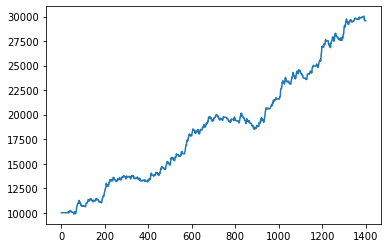

In [150]:
for i, x in enumerate(S[:-1], 0):
    if arima2_prediction[i] == x:
        w[i+1] = w[i]
        cash[i+1] = cash[i]

    if arima2_prediction[i] < x: 
        w[i+1] = cash[i]/x  + w[i]
        cash[i+1] = 0

    if arima2_prediction[i] > x:
        cash[i+1] = w[i]*x + cash[i]
        w[i+1] = 0


arima2_strategy = [a*b for a,b in zip(w,S)]+ cash


#plt.plot(t, mr_strategy)
plt.plot(arima2_strategy)
plt.show()

In [151]:
arima2_strategy=pd.DataFrame(arima2_strategy)
arima2_strategy["returns"]=np.log(arima2_strategy.iloc[:,0]/arima2_strategy.iloc[:,0].shift())
arima2_strategy["cum returns"]=arima2_strategy["returns"].cumsum()+1
print("Cumulative log returns of ARIMA strategy is: "+ str(arima2_strategy["cum returns"].iloc[-1]))
print("Cumulative log returns of buy and hold is: "+ str(df_train_opt["cum returns buy and hold"].iloc[-1]))
print("Annualised sharpe ARIMA GARCH: " + str(annualised_sharpe(arima2_strategy["returns"])))
print("Annualised sharpe buy and hold: " + str(annualised_sharpe(df_train_opt["returns"])))

Cumulative log returns of ARIMA strategy is: 2.0844890902847353
Cumulative log returns of buy and hold is: 1.66709138651777
Annualised sharpe ARIMA GARCH: 2.4651569134242863
Annualised sharpe buy and hold: 2.463615804664129


## Test performance

In [156]:
time_window = 30
cumsum = [0]
S=df_test["Close Price"]
arima2test_prediction = np.zeros(np.shape(S))
w = np.zeros(np.shape(S))
cash_test = np.zeros(np.shape(S))

cash_test[0] = cash[-1]

In [157]:
for i, x in enumerate(S[:-1], 0):
    arima2test_prediction[i] = x
    try:
        if i>=time_window:
            X = log_ret_test[0:i]
            TS = X
            res_tup = _get_best_model(TS)
            order = res_tup[1]
            model = res_tup[2]

            #now that we have our ARIMA fit, we feed this to GARCH model
            p_ = max(order[0],1)
            #o_ = order[1]
            q_ = order[1]

            #print (train)
            # train ARIMA
            am = arch_model(model.resid, p=p_,q=q_, dist='StudentsT')
            res = am.fit(update_freq=5, disp='off')
            # Generate a forecast of next day return using our fitted model
            out = res.forecast(horizon=1, start=None, align='origin')
            #print(out)

            predictions=out.mean['h.1'].iloc[-1]    
            arima2test_prediction[i] =np.exp(predictions)*y[i-1]
            print(arima2test_prediction[i])
    except:
        pass


aic: -227.57 | order: (0, 0)
113.0726710780627
aic: -236.28 | order: (0, 0)
113.46718343981755
aic: -244.78 | order: (0, 0)
34.72209578721806
aic: -252.59 | order: (0, 0)
159.1761410876859
aic: -261.38 | order: (0, 0)
44.35666022127896
aic: -269.72 | order: (0, 0)
113.56113471037513
aic: -277.72 | order: (0, 0)
aic: -286.50 | order: (0, 0)
aic: -294.81 | order: (0, 0)
1.3515206571850976e-68
aic: -299.76 | order: (0, 0)
117.64309527798058
aic: -308.56 | order: (0, 0)
169.8945608765409
aic: -313.64 | order: (0, 0)
0.07086934126080674
aic: -322.06 | order: (1, 1)
117.03667966147249
aic: -330.87 | order: (1, 1)
117.73130455006053
aic: -339.09 | order: (1, 1)
117.94023718840897
aic: -347.88 | order: (1, 1)
117.69533142694846
aic: -355.65 | order: (2, 2)
118.22920161550613
aic: -364.63 | order: (2, 2)
117.19866117721533
aic: -371.07 | order: (1, 1)
116.51451449774446
aic: -379.06 | order: (1, 1)
116.44061780189284
aic: -386.04 | order: (1, 1)
116.33184593672277
aic: -394.18 | order: (1, 1)
1

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -656.94 | order: (1, 1)
128.3240442301909
aic: -663.90 | order: (1, 1)
126.36655304701438
aic: -671.91 | order: (1, 1)
126.47629947962875
aic: -679.16 | order: (2, 2)
125.97579629396019
aic: -686.09 | order: (2, 1)
124.4151555405134
aic: -694.32 | order: (3, 2)
124.89292197186144


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -702.52 | order: (2, 1)
124.20107062073654
aic: -708.66 | order: (2, 1)
124.11756063962925
aic: -717.00 | order: (2, 1)
123.88316413671747
aic: -724.91 | order: (1, 1)
122.81742971839694
aic: -734.66 | order: (4, 2)
121.0538120799954
aic: -742.55 | order: (4, 2)
119.92778462160946
aic: -750.00 | order: (1, 1)
117.43808090829482
aic: -759.08 | order: (4, 3)
29.446599741875893
aic: -766.74 | order: (1, 1)
118.32219676494753
aic: -775.27 | order: (1, 1)
117.66812199922505
aic: -779.93 | order: (1, 1)
115.86074532206383
aic: -788.56 | order: (1, 1)
115.72766676337935
aic: -793.23 | order: (1, 1)
114.7301883682808
aic: -797.66 | order: (1, 1)
116.76378957327597


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -806.27 | order: (1, 1)
113.5664627973444
aic: -812.81 | order: (1, 1)
105.68210843543399
aic: -821.27 | order: (2, 1)
113.24206774527222
aic: -829.86 | order: (2, 1)
111.54091127339834
aic: -838.32 | order: (2, 1)
110.60057667476134
aic: -846.55 | order: (2, 1)
109.67502165591083
aic: -854.63 | order: (1, 1)
aic: -862.45 | order: (1, 1)
24.168801067257196
aic: -868.23 | order: (1, 1)
45.10633282784747
aic: -876.02 | order: (1, 1)
174.19390545629417
aic: -881.96 | order: (1, 1)
16.82206177998665
aic: -888.30 | order: (1, 1)
113.7432810607985
aic: -895.84 | order: (2, 1)
113.99600365569714
aic: -904.39 | order: (2, 1)
114.80610321973141
aic: -912.74 | order: (2, 1)
115.12337751618374
aic: -921.19 | order: (2, 1)
115.42455719208546
aic: -929.84 | order: (2, 1)
116.26693095157411
aic: -938.18 | order: (2, 1)
117.6696734938256
aic: -944.65 | order: (2, 1)
116.17937629427888
aic: -952.86 | order: (2, 1)
114.99863881269074
aic: -961.05 | order: (2, 1)
115.54953843552879
aic: -963.45 | o

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1042.67 | order: (2, 1)
115.89907143037104
aic: -1048.98 | order: (2, 1)
116.07701555213245
aic: -1058.44 | order: (2, 2)
7.996626982503964e-05
aic: -1064.94 | order: (2, 1)
114.54062972057245


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1073.33 | order: (2, 1)
0.0
aic: -1081.59 | order: (2, 1)
115.2351401538021
aic: -1089.37 | order: (2, 1)
3082.4109665190304
aic: -1095.20 | order: (2, 1)
114.44871698102406
aic: -1100.46 | order: (2, 1)
112.51144310085455


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1105.56 | order: (2, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


114.21859190295469
aic: -1114.11 | order: (2, 3)
0.09812343248830376
aic: -1121.71 | order: (3, 3)
115.93192787673121
aic: -1132.33 | order: (2, 2)
2817.220700123007


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1137.31 | order: (3, 3)
53.75433420371363
aic: -1144.85 | order: (2, 3)
13.096224834384316
aic: -1154.02 | order: (2, 1)
116.25874646634227
aic: -1162.47 | order: (2, 1)
115.58061298284728
aic: -1170.72 | order: (3, 3)
inf
aic: -1179.26 | order: (3, 3)
6786.230587597604
aic: -1185.96 | order: (2, 1)
117.52217357565546
aic: -1194.35 | order: (3, 3)
aic: -1202.87 | order: (3, 3)
113.15130009725249
aic: -1209.80 | order: (3, 3)
3.9841223106135124
aic: -1217.31 | order: (3, 3)
aic: -1219.31 | order: (2, 3)
inf
aic: -1227.92 | order: (3, 3)
119.77203797972729
aic: -1236.15 | order: (2, 3)
118.11397248978804


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1244.41 | order: (2, 3)
117.54395827305983


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1252.07 | order: (3, 3)
aic: -1260.63 | order: (3, 3)
113.65981550775014
aic: -1269.09 | order: (3, 3)
aic: -1277.56 | order: (3, 3)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1277.98 | order: (3, 3)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1283.58 | order: (2, 2)
115.0249147574299
aic: -1290.43 | order: (2, 2)
inf
aic: -1298.83 | order: (2, 2)
116.97202946994881
aic: -1307.38 | order: (2, 2)
7.011905531805185
aic: -1314.45 | order: (0, 3)
0.24810835084498478
aic: -1322.86 | order: (0, 3)
71.58312319883665


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1331.15 | order: (0, 3)
531.3135507792928
aic: -1339.51 | order: (0, 3)
61.73810548933234
aic: -1347.98 | order: (0, 3)
117.91753540407545


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1354.41 | order: (2, 3)
276.7111811791235
aic: -1361.52 | order: (3, 3)
1.8763982436271576e-05
aic: -1369.71 | order: (3, 3)
112.2346827965244
aic: -1377.33 | order: (3, 3)
112.45396435212827
aic: -1385.10 | order: (2, 2)
112.16312603799393
aic: -1391.84 | order: (3, 3)
113.07007297504062
aic: -1400.33 | order: (3, 3)
83.42348658911615


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1407.48 | order: (0, 3)
11.32679404267228


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1416.38 | order: (3, 3)
3.5706789647870636
aic: -1424.88 | order: (3, 2)
117.1698603014743


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1432.50 | order: (0, 3)
119.36411683100395


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1439.82 | order: (0, 3)
118.49737207767666


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1448.36 | order: (0, 3)
aic: -1456.10 | order: (0, 3)
120.91179978329934


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1464.57 | order: (0, 3)
119.12323053958927
aic: -1471.33 | order: (0, 3)
aic: -1478.40 | order: (0, 3)
119.93452071226442
aic: -1485.65 | order: (0, 3)
122.43795901495615
aic: -1492.84 | order: (0, 3)
aic: -1501.25 | order: (0, 3)
86.76274595142253
aic: -1509.28 | order: (0, 3)
0.0
aic: -1517.67 | order: (0, 3)
128.62660993401687


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1525.47 | order: (0, 3)
143.9715847948846
aic: -1530.46 | order: (0, 3)
128.66927046902666


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1536.74 | order: (0, 3)
312.65705468093455
aic: -1544.74 | order: (0, 3)
129.09910403961337


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1552.85 | order: (0, 3)
132.09605949062225
aic: -1561.39 | order: (0, 3)
5.950217731947241e-06
aic: -1569.12 | order: (0, 3)
6.833722231377431e+91


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1576.43 | order: (0, 3)
0.6291996169736626


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1584.98 | order: (0, 3)
133.7316051393923
aic: -1590.68 | order: (3, 0)
105.02618603540277
aic: -1599.03 | order: (3, 0)
132.180670946428
aic: -1603.12 | order: (2, 2)
132.89727074873386
aic: -1611.52 | order: (2, 2)
72.78322361553938
aic: -1618.84 | order: (2, 2)
133.3934530344906
aic: -1623.09 | order: (2, 2)
57.073562113037646
aic: -1631.60 | order: (2, 2)
141.97987465631618


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1640.14 | order: (2, 2)
135.71247755484083
aic: -1646.44 | order: (2, 2)
137.81864567978405
aic: -1654.26 | order: (2, 2)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1660.88 | order: (2, 2)
138.753307792006
aic: -1667.49 | order: (2, 2)
140.9105240612182
aic: -1677.14 | order: (2, 2)
141.80107856770263
aic: -1685.67 | order: (2, 2)
0.07316754967570643
aic: -1692.24 | order: (3, 3)
90.46137793800204


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1700.37 | order: (2, 2)
3.970304230895034
aic: -1707.68 | order: (2, 2)
144.39441098049488
aic: -1716.09 | order: (2, 2)
144.51370730157277
aic: -1723.82 | order: (2, 2)
144.01516485834298
aic: -1732.33 | order: (2, 2)
142.97811254597318
aic: -1740.89 | order: (2, 2)
143.25729229387767
aic: -1746.82 | order: (2, 2)
142.64970498643052
aic: -1754.01 | order: (2, 2)
93.49532772258608
aic: -1762.47 | order: (2, 2)
142.2759343785255


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1771.02 | order: (2, 2)
141.52454983137832
aic: -1778.85 | order: (2, 2)
17747302.66534118
aic: -1784.95 | order: (2, 2)
105.15107233194075
aic: -1793.50 | order: (2, 2)
146.2339880248676
aic: -1801.80 | order: (2, 2)
147.25213436815247
aic: -1809.63 | order: (2, 2)
140.44536002152418
aic: -1814.16 | order: (1, 0)
159.88896798362742
aic: -1822.15 | order: (2, 2)
423.7999155190136
aic: -1832.15 | order: (2, 2)
145.78008197636103
aic: -1832.97 | order: (1, 0)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1840.25 | order: (1, 0)
146.52548087959676


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1848.71 | order: (1, 0)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1856.82 | order: (1, 0)
250.4165342113108
aic: -1864.99 | order: (1, 0)
139.08561398255245
aic: -1873.40 | order: (1, 0)
3784.746708726487
aic: -1881.70 | order: (1, 0)
111.32683506821682
aic: -1890.18 | order: (1, 0)
139.50687020122322
aic: -1897.51 | order: (1, 0)
138.68860187623952
aic: -1906.03 | order: (1, 0)
122.00338942316095
aic: -1913.14 | order: (1, 0)
140.13250048382451
aic: -1921.65 | order: (1, 0)
140.45035415436533
aic: -1929.74 | order: (2, 2)
aic: -1936.15 | order: (1, 0)
28.95371091858547
aic: -1944.65 | order: (1, 0)
147.13905982958164
aic: -1953.19 | order: (1, 0)
122.74694318729347
aic: -1961.58 | order: (1, 0)
inf
aic: -1970.12 | order: (1, 0)
702.7292507756158
aic: -1978.72 | order: (2, 2)
216.30955437229346
aic: -1986.38 | order: (2, 2)
176.1650402860101


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -1993.95 | order: (2, 2)
104.00846078916032
aic: -2002.44 | order: (2, 2)
433.5709789698976
aic: -2009.43 | order: (2, 2)
142.36701087349766


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2017.99 | order: (2, 2)
inf
aic: -2025.23 | order: (2, 2)
144.8648279927695
aic: -2033.74 | order: (2, 2)
aic: -2040.32 | order: (1, 0)
144.03967322714348


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2048.47 | order: (1, 0)
aic: -2057.43 | order: (2, 2)
4137811574277.774


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2065.73 | order: (2, 2)
1382207.368461153


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2074.27 | order: (2, 2)
145.41159419087307
aic: -2081.23 | order: (1, 0)
144.86833198203098
aic: -2090.17 | order: (2, 2)
136.43085723607982


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2097.48 | order: (1, 0)
55.48307366570057
aic: -2104.06 | order: (1, 0)
147.50619149394365
aic: -2112.26 | order: (1, 0)
326.92708987906326
aic: -2118.07 | order: (1, 0)
aic: -2126.62 | order: (1, 0)
149.74850189192392
aic: -2134.59 | order: (1, 0)
aic: -2141.30 | order: (2, 2)
151.59798838215875


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2149.32 | order: (2, 2)
151.82010767078685
aic: -2157.76 | order: (3, 3)
466.7917405010377


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2166.44 | order: (3, 3)
153.56469316775056
aic: -2174.70 | order: (2, 2)
inf
aic: -2183.26 | order: (2, 2)
aic: -2191.45 | order: (2, 2)
147.49799686292354
aic: -2200.03 | order: (2, 2)
6.520294402551623
aic: -2208.07 | order: (2, 2)
152.08299944120972
aic: -2216.24 | order: (2, 2)
151.1492126859028
aic: -2224.31 | order: (2, 2)
1256.1981119575064


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2231.57 | order: (2, 2)
149.45360509257557
aic: -2238.13 | order: (1, 0)
12831790.210567852
aic: -2248.09 | order: (2, 2)
5.526602015252459
aic: -2255.65 | order: (2, 2)
146.2766060641279
aic: -2264.25 | order: (2, 2)
aic: -2272.66 | order: (2, 2)
148.0968838533799
aic: -2281.18 | order: (2, 2)
149.42681702309446
aic: -2289.51 | order: (2, 2)
148.49427715776918
aic: -2297.92 | order: (2, 2)
aic: -2304.68 | order: (2, 2)
171.90973248742606


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2312.50 | order: (2, 2)
144.34647942291494
aic: -2318.98 | order: (2, 2)
145.5446540804262


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2327.57 | order: (2, 2)
315.12896992101315
aic: -2336.07 | order: (2, 2)
145.79556359039944
aic: -2339.11 | order: (1, 0)
144.59623413017138
aic: -2347.37 | order: (1, 0)
635.1091075736545
aic: -2355.71 | order: (1, 0)
142.0042749210895
aic: -2363.79 | order: (1, 0)
143.11845164157614
aic: -2371.80 | order: (1, 0)
575122157.1883047
aic: -2380.15 | order: (1, 0)
56.08414366389823
aic: -2388.73 | order: (1, 0)
141.4882408283143
aic: -2397.32 | order: (1, 0)
141.18461267218245
aic: -2405.32 | order: (1, 0)
140.98147835457334
aic: -2413.09 | order: (1, 0)
141.78449760012148
aic: -2421.53 | order: (1, 0)
249.87708959842095
aic: -2429.13 | order: (1, 0)
335.95298771646253
aic: -2437.52 | order: (1, 0)
139.42459817732288
aic: -2445.83 | order: (1, 0)
141.38644050019948
aic: -2454.10 | order: (1, 0)
142.31627329461492
aic: -2462.70 | order: (1, 0)
142.30277833202265
aic: -2467.61 | order: (1, 0)
143.81579102050793
aic: -2474.99 | order: (1, 0)
143.2970355579532
aic: -2483.52 | order: (1,

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


143.34754715063647
aic: -2512.09 | order: (0, 2)
143.69328383457076
aic: -2520.45 | order: (0, 2)
142.77766548121622
aic: -2528.76 | order: (0, 2)
143.2882215512184
aic: -2536.52 | order: (0, 2)
143.8416105033805
aic: -2544.67 | order: (0, 2)
141.32658968673698
aic: -2553.29 | order: (0, 2)
139.5707169719682
aic: -2561.26 | order: (0, 2)
139.17497265775813
aic: -2567.22 | order: (0, 2)
138.0631895285671
aic: -2575.66 | order: (0, 2)
139.37130322999798


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -2583.35 | order: (0, 2)
137.86124379863648
aic: -2591.98 | order: (0, 2)
136.79952400416587
aic: -2600.49 | order: (0, 2)
137.80297182477443
aic: -2609.10 | order: (0, 2)
138.34291086140996
aic: -2617.05 | order: (0, 2)
138.45804793783427
aic: -2625.66 | order: (0, 2)
138.39968094308887
aic: -2633.63 | order: (1, 0)
5.0605668377552885e-244
aic: -2642.26 | order: (0, 2)
138.83324620923224
aic: -2648.79 | order: (1, 0)
0.0
aic: -2654.74 | order: (1, 0)
138.83530594836984
aic: -2663.34 | order: (1, 0)
inf
aic: -2671.75 | order: (1, 0)
140.12217506951043
aic: -2678.76 | order: (1, 0)
139.32961119033152
aic: -2686.63 | order: (1, 0)
139.666394427121
aic: -2694.84 | order: (1, 0)
5.3759124638186455e+19
aic: -2702.78 | order: (1, 0)
135.76918439474878
aic: -2711.41 | order: (1, 0)
134.50668264005068
aic: -2717.67 | order: (1, 0)
76.67549110684925
aic: -2726.24 | order: (1, 0)
133.16772155174203
aic: -2734.78 | order: (1, 0)
133.39467833175493
aic: -2741.04 | order: (1, 0)
134.6162712854

C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3103.38 | order: (1, 0)
aic: -3111.05 | order: (1, 0)
117.37045999781967
aic: -3118.63 | order: (1, 0)
1.6815894181528323e-06
aic: -3126.25 | order: (1, 0)
118.47619902969588
aic: -3132.60 | order: (1, 0)
83.34082866642117
aic: -3138.59 | order: (1, 0)
121.16764470093464


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3147.17 | order: (1, 0)
121.93598220664475
aic: -3154.76 | order: (1, 0)
aic: -3163.23 | order: (1, 0)
0.0
aic: -3172.39 | order: (4, 2)
125.34456267955251


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3176.93 | order: (2, 0)
125.16690305683511
aic: -3185.19 | order: (1, 0)
125.37541758831688
aic: -3193.65 | order: (1, 0)
123.7159220598279
aic: -3202.14 | order: (1, 0)
aic: -3211.28 | order: (4, 2)
123.69817880971628


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3218.21 | order: (2, 3)
4.3050174121339303e-13


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3226.34 | order: (2, 3)
aic: -3234.97 | order: (2, 3)
inf
aic: -3243.38 | order: (2, 3)
109753.44906255507
aic: -3252.02 | order: (2, 3)
0.0
aic: -3262.96 | order: (3, 2)
123.48930957501624
aic: -3269.43 | order: (2, 3)
aic: -3277.90 | order: (2, 3)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


152.06776160453876
aic: -3286.22 | order: (2, 3)
0.0
aic: -3297.47 | order: (3, 3)
125.33276323074497
aic: -3303.07 | order: (2, 3)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3310.27 | order: (2, 3)
112.72211841838912
aic: -3318.84 | order: (2, 3)
0.0
aic: -3327.55 | order: (2, 3)
127.26123503312311
aic: -3335.89 | order: (2, 3)
aic: -3346.43 | order: (3, 3)
132.47256074903356
aic: -3351.82 | order: (2, 3)
aic: -3360.39 | order: (2, 3)
131.32992796663964
aic: -3369.06 | order: (2, 3)
134.9210401270786


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3377.78 | order: (2, 3)
137.11023880284662
aic: -3385.83 | order: (2, 3)
129.9468357503584
aic: -3393.33 | order: (2, 3)
130.39459380416338
aic: -3401.96 | order: (2, 3)
685.596705563326
aic: -3410.64 | order: (2, 3)
129.1112811544644
aic: -3419.65 | order: (3, 3)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3425.09 | order: (2, 3)
126.32196844911896
aic: -3433.79 | order: (2, 3)
126.6080092919197
aic: -3442.48 | order: (2, 3)
125.41694803038612
aic: -3445.58 | order: (2, 0)
123.48054319337824
aic: -3453.63 | order: (2, 0)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3461.94 | order: (2, 0)
119.6518263099655
aic: -3470.22 | order: (2, 0)
125.30174720538545
aic: -3478.92 | order: (2, 0)
aic: -3486.19 | order: (2, 0)
14224.697374449184
aic: -3495.43 | order: (4, 2)
125.9518139095648
aic: -3503.42 | order: (4, 2)
126.12959459725093
aic: -3513.54 | order: (4, 2)
117.72898812348019
aic: -3515.74 | order: (2, 0)
aic: -3524.45 | order: (2, 0)
130.26501617200114
aic: -3534.01 | order: (4, 2)
130.89144050278134
aic: -3540.58 | order: (2, 0)
77.76617404384588
aic: -3548.38 | order: (2, 0)
184049.34576937868
aic: -3556.50 | order: (2, 0)
133.1514376900365
aic: -3564.70 | order: (2, 0)
120.33919786118958


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3574.11 | order: (4, 2)
133.17129576796873
aic: -3581.94 | order: (2, 0)
129.61231669599152
aic: -3590.30 | order: (2, 0)
aic: -3596.26 | order: (2, 0)
128.60858639895514
aic: -3603.23 | order: (2, 0)
94.20856422486617
aic: -3611.28 | order: (2, 0)
aic: -3620.00 | order: (2, 0)
126.15094737880274
aic: -3626.76 | order: (2, 0)
aic: -3633.35 | order: (2, 0)
129.23994768893664
aic: -3641.58 | order: (2, 0)
123.46963860155162
aic: -3648.80 | order: (2, 0)
122.63124367558048


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3657.12 | order: (2, 0)
aic: -3665.76 | order: (2, 0)
119.73290009431928
aic: -3673.81 | order: (2, 0)
aic: -3682.39 | order: (2, 0)
117.84381348907972
aic: -3690.91 | order: (2, 0)
119.00935032519226
aic: -3696.71 | order: (2, 0)
121.14743519243096
aic: -3702.64 | order: (4, 2)
121.2188907766984
aic: -3715.05 | order: (3, 2)
inf
aic: -3719.76 | order: (2, 0)
0.0
aic: -3726.98 | order: (0, 2)
125.0460632862807


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3734.99 | order: (2, 0)
aic: -3747.45 | order: (3, 2)
125.00904190773801
aic: -3754.77 | order: (3, 2)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3756.83 | order: (0, 2)
aic: -3771.30 | order: (3, 2)
128.26525476571487


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3773.67 | order: (0, 2)
127.69985633918753
aic: -3781.53 | order: (0, 2)
aic: -3795.22 | order: (3, 2)
127.07593548909047
aic: -3803.88 | order: (3, 2)
125.80197952132984
aic: -3812.59 | order: (3, 2)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3821.30 | order: (3, 2)
125.4108530891408
aic: -3823.89 | order: (0, 2)
4.274267360060492e+17
aic: -3832.28 | order: (0, 2)
aic: -3838.44 | order: (0, 2)
125.95717932636742


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3847.13 | order: (0, 2)
87.16194186873322
aic: -3855.27 | order: (2, 0)
4.858183517949089e+32
aic: -3863.79 | order: (2, 0)
128.85135434320446
aic: -3872.52 | order: (2, 0)
120564586612541.78
aic: -3879.40 | order: (0, 2)
126.6750515079277
aic: -3893.31 | order: (3, 2)
128.1317095600321
aic: -3895.83 | order: (0, 2)
125.86647378307903


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3909.21 | order: (3, 2)
9.73161856169375
aic: -3910.49 | order: (0, 2)
129.98674425086506
aic: -3914.88 | order: (2, 4)
0.1062428727259879
aic: -3921.01 | order: (3, 2)
inf
aic: -3929.69 | order: (3, 2)
130.5333986590772
aic: -3942.99 | order: (3, 2)
132.13400350354829
aic: -3947.23 | order: (2, 4)
133.39270584614718
aic: -3960.04 | order: (3, 2)
130.25501440723787
aic: -3964.44 | order: (2, 4)
132.43803158998577
aic: -3972.41 | order: (2, 4)
133.84256357001286
aic: -3980.68 | order: (2, 4)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -3992.78 | order: (3, 2)
aic: -4000.78 | order: (3, 2)
135.60312748555341
aic: -4001.38 | order: (2, 4)
134.44207981957172


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4012.54 | order: (3, 2)
134.68627846395404
aic: -4021.25 | order: (3, 2)
131.49332557037334
aic: -4028.82 | order: (3, 2)
135.72015129187952


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4037.40 | order: (3, 2)
138.37901510564586


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4045.52 | order: (3, 2)
138.86026479732809
aic: -4054.85 | order: (3, 2)
139.49795994636625
aic: -4063.24 | order: (3, 2)
71.6415967147585
aic: -4069.96 | order: (2, 4)
aic: -4079.33 | order: (3, 2)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4086.34 | order: (2, 4)
139.66769319558898
aic: -4095.04 | order: (2, 4)
141.95362204887
aic: -4103.81 | order: (2, 4)
141.28733933593418
aic: -4111.73 | order: (2, 4)
140.62480975776649
aic: -4120.37 | order: (2, 4)
140.58973661080287
aic: -4129.08 | order: (2, 4)
inf
aic: -4133.65 | order: (2, 4)
139.55843196105187
aic: -4141.50 | order: (2, 4)
137.3882104340319
aic: -4146.32 | order: (0, 2)
135.81813631583617
aic: -4154.37 | order: (0, 2)
136.79976555987517
aic: -4162.83 | order: (0, 2)
135.752737515294
aic: -4170.37 | order: (0, 2)
136.22751667539708
aic: -4178.84 | order: (3, 4)
142.65637179653493
aic: -4191.17 | order: (3, 2)
136.45849182669295
aic: -4199.38 | order: (3, 2)
135.90923787363266
aic: -4208.11 | order: (3, 2)
0.0
aic: -4216.80 | order: (3, 2)
187.3504295792024


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4224.70 | order: (3, 2)
133.98985400710035
aic: -4228.29 | order: (3, 4)
133.27212380520552
aic: -4241.95 | order: (3, 2)
0.0


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4250.81 | order: (3, 2)
134.48075949557946
aic: -4259.54 | order: (3, 2)
134.15150111352636


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4259.57 | order: (3, 4)
134.40193897703992
aic: -4272.91 | order: (3, 2)
135.16247170533345
aic: -4281.21 | order: (3, 2)
137.31619256240435
aic: -4284.63 | order: (3, 4)
135.21083262375313
aic: -4298.50 | order: (3, 2)
137.42261297243184
aic: -4307.15 | order: (3, 2)
137.85370244284312
aic: -4308.49 | order: (3, 4)
aic: -4320.82 | order: (3, 2)
135.92279474968993
aic: -4329.58 | order: (3, 2)
150.95096877179148


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4332.57 | order: (3, 4)
137.07493348062192
aic: -4346.68 | order: (3, 2)
136.9272800051468
aic: -4349.38 | order: (3, 2)
136.8167882661686
aic: -4356.58 | order: (3, 2)
136.0230134584259
aic: -4363.77 | order: (3, 2)
aic: -4371.99 | order: (3, 2)
133.739146095028
aic: -4378.43 | order: (3, 2)
0.0002125170661575029


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4387.17 | order: (3, 2)
inf


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4394.97 | order: (3, 2)
135.15846973987456
aic: -4402.64 | order: (3, 2)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


135.9744294483408
aic: -4411.31 | order: (3, 2)
85.87463801796318
aic: -4420.02 | order: (3, 2)
137.20800379499778
aic: -4428.60 | order: (3, 2)
2.993424408605621e+16
aic: -4437.18 | order: (3, 2)
140.33036688870925
aic: -4445.82 | order: (3, 2)
141.84459580179933
aic: -4453.45 | order: (3, 2)
141.73571092042357
aic: -4462.09 | order: (3, 2)
142.42311544516693
aic: -4469.49 | order: (3, 2)
144.7946437795738
aic: -4474.94 | order: (3, 4)
aic: -4482.58 | order: (3, 2)
146.7151424818991
aic: -4490.80 | order: (3, 2)
146.71006057303453
aic: -4499.07 | order: (3, 2)
0.0
aic: -4507.79 | order: (3, 2)
136.6710917691584
aic: -4516.55 | order: (3, 2)
14122.391867374221
aic: -4524.33 | order: (3, 4)
2.0494373361543424e-46
aic: -4526.45 | order: (3, 4)
150.65136844065245
aic: -4533.43 | order: (3, 4)
152.08941123698682


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4542.17 | order: (3, 4)
aic: -4550.74 | order: (3, 4)
153.57911139912036
aic: -4559.45 | order: (3, 4)
154.0846544069176
aic: -4566.50 | order: (3, 4)
153.61591783113246
aic: -4575.27 | order: (3, 4)
136.17442309102012
aic: -4583.58 | order: (3, 4)
152.85580656608198
aic: -4591.00 | order: (3, 4)
152.24288229412417
aic: -4599.74 | order: (3, 4)
152.28509794317577


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


aic: -4608.52 | order: (3, 4)
166.82423187358447
aic: -4617.30 | order: (3, 4)


C:\Users\redon\anaconda3\lib\site-packages\arch\univariate\base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


152.77497881539588
aic: -4626.06 | order: (3, 4)
9.363683742601983e-20
aic: -4634.31 | order: (3, 4)
152.7715434291932


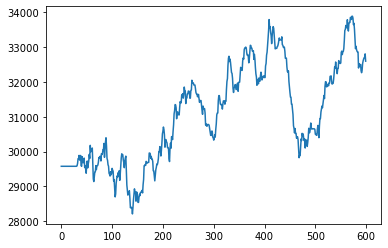

In [158]:
for i, x in enumerate(S[:-1], 0):
    if arima2test_prediction[i] == x:
        w[i+1] = w[i]
        cash_test[i+1] = cash_test[i]

    if arima2test_prediction[i] < x: 
        w[i+1] = cash_test[i]/x  + w[i]
        cash_test[i+1] = 0

    if arima2test_prediction[i] > x:
        cash_test[i+1] = w[i]*x + cash_test[i]
        w[i+1] = 0


arima2test_strategy = [a*b for a,b in zip(w,S)]+ cash_test


#plt.plot(t, mr_strategy)
plt.plot(arima2test_strategy)
plt.show()

In [167]:
arima2test_strategy=pd.DataFrame(arima2test_strategy)
ret_test_garch=np.log(arima2test_strategy/arima2test_strategy.shift()).dropna()

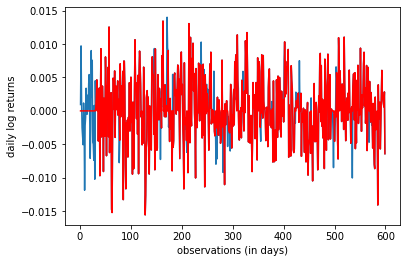

In [168]:
plt.plot(log_ret_test)
plt.plot(ret_test_garch, color='r')
plt.xlabel("observations (in days)")
plt.ylabel("daily log returns")
#print(f"fitted AR parameter {arparams[0]:.2f}, MA parameter {maparams[0]:.2f}")
plt.savefig("returnsgarchtest.png")

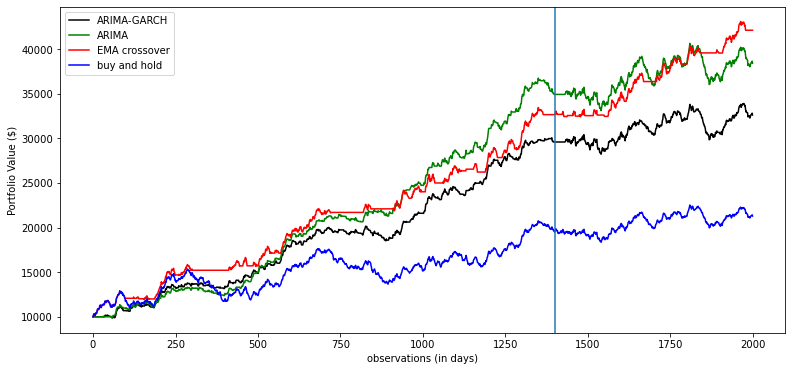

In [174]:
plt.figure(figsize=(13,6))
garch_total_strategy=arima2_strategy.iloc[:,0].append(arima2test_strategy.iloc[:,0],ignore_index=True)
plt.plot(garch_total_strategy,'k')
plt.plot(arima_total_strategy,'g')
plt.plot(EMA_total_strategy,'r')
plt.plot(buy_hold_value,'b')
plt.xlabel('observations (in days)')
plt.ylabel('Portfolio Value ($)')
plt.legend(['ARIMA-GARCH','ARIMA','EMA crossover','buy and hold'])
plt.axvline(x=len(df_train))
plt.savefig("garch.png")

# Performance indicators

In [175]:
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())

In [240]:
def conditional_sharpe(returns,alpha):
    returns=returns.dropna()
    returns.sort_values(inplace = True, ascending = True)
    VaR= returns.quantile(alpha)
    ES= returns[returns.lt(VaR, axis=0)].mean()
    return np.sqrt(N) *(returns.mean()/abs(ES))

In [201]:
#https://oxfordstrat.com/coasdfASD32/uploads/2016/03/How-Sharp-Is-the-Sharpe-Ratio.pdf
def max_drawdown(returns):
    returns=returns.dropna()
    comp_ret = (returns+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

def calmar(returns):
    returns=returns.dropna()
    return returns.mean()*255/abs(max_drawdown(returns))

In [202]:
returns_EMA=np.log(df_train_opt["strategy"]/df_train_opt["strategy"].shift()).dropna()
returns_buyhold=np.log(df_train_opt["Close Price"]/df_train_opt["Close Price"].shift()).dropna()
returns_arima=np.log(arima_strategy.iloc[:,0]/arima_strategy.iloc[:,0].shift()).dropna()
returns_garch=np.log(arima2_strategy.iloc[:,0]/arima2_strategy.iloc[:,0].shift()).dropna()

## Training set

In [179]:
annualised_sharpe(returns_buyhold),annualised_sharpe(returns_EMA),annualised_sharpe(returns_arima),annualised_sharpe(returns_garch)

(1.0538246773150914, 2.463615804664129, 2.916495007133527, 2.4651569134242863)

In [241]:
conditional_sharpe(returns_buyhold,0.05),conditional_sharpe(returns_EMA,0.05),conditional_sharpe(returns_arima,0.05),conditional_sharpe(returns_garch,0.05)

(1.431456864908619, 3.271288734141476, 3.959495780208451, 3.3076826690521077)

In [181]:
calmar(returns_buyhold),calmar(returns_EMA),calmar(returns_arima),calmar(returns_garch)

(0.5092925048480097, 2.9643988570834816, 3.18129313182935, 2.4303902816150886)

## Test set

In [232]:
buy_hold_value=pd.DataFrame(buy_hold_value)
returns_buy_test=np.log(buy_hold_value/buy_hold_value.shift()).dropna()[len(returns_buyhold):]
returns_EMA_test=data["returns"].dropna()
returns_arima_test=np.log(arimatest_strategy/arimatest_strategy.shift()).dropna()
returns_garch_test=np.log(arima2test_strategy/arima2test_strategy.shift()).dropna()

In [247]:
annualised_sharpe(returns_buy_test),annualised_sharpe(returns_EMA_test),annualised_sharpe(returns_arima_test.iloc[:,0]),annualised_sharpe(returns_garch_test.iloc[:,0])

(0    0.460601
 dtype: float64,
 2.284158816681363,
 0.5106254947814558,
 0.5542257394115879)

In [250]:
conditional_sharpe(returns_buy_test.iloc[:,0],0.05),conditional_sharpe(returns_EMA_test,0.05),conditional_sharpe(returns_arima_test.iloc[:,0],0.05),conditional_sharpe(returns_garch_test.iloc[:,0],0.05)

(0.6153840909170417,
 2.9833050833230894,
 0.6748713270012964,
 0.6977987418945938)

In [251]:
calmar(returns_buy_test),calmar(returns_EMA_test),calmar(returns_arima_test),calmar(returns_garch_test)

(0    0.328709
 dtype: float64,
 2.522403994795131,
 0    0.354803
 dtype: float64,
 0    0.350934
 dtype: float64)

# Statistical tests

In [253]:
def tstat(returns):
    return np.sqrt(len(returns))*(returns.mean() / returns.std()), len(returns)-1

In [254]:
tstat(returns_arima)[0]

6.871789130193787

In [255]:
from scipy import stats

In [256]:
# p-value arima
t=tstat(returns_arima)[0]
df=tstat(returns_arima)[1]
p = 1 - stats.t.cdf(t,df)
p, p*4, p*4

(4.759859173475434e-12, 1.9039436693901735e-11, 1.9039436693901735e-11)

In [257]:
# p-value EMA
t=tstat(returns_EMA)[0]
df=tstat(returns_EMA)[1]
p = 1 - stats.t.cdf(t,df)
p, p*4, p*3

(3.98321775563204e-09, 1.593287102252816e-08, 1.1949653266896121e-08)

In [258]:
# p-value garch
t=tstat(returns_garch)[0]
df=tstat(returns_garch)[1]
p = 1 - stats.t.cdf(t,df)
p, p*4,p*2

(3.899795375517101e-09, 1.5599181502068404e-08, 7.799590751034202e-09)

In [259]:
# p-value buy and hold
t=tstat(returns_buyhold)[0]
df=tstat(returns_buyhold)[1]
p = 1 - stats.t.cdf(t,df)
p, p*4, p*1

(0.0065723080348077945, 0.026289232139231178, 0.0065723080348077945)

## Test set

In [269]:
# p-value EMA
t=tstat(returns_EMA_test)[0]
df=tstat(returns_EMA_test)[1]
p = 1 - stats.t.cdf(t,df)
p,p*4,p*4

(7.792611000922989e-11, 3.1170444003691955e-10, 3.1170444003691955e-10)

In [270]:
t=tstat(returns_garch_test)[0]
df=tstat(returns_garch_test)[1]
p = 1 - stats.t.cdf(t,df)
p,p*4,p*3

(array([0.19659176]), array([0.78636704]), array([0.58977528]))

In [271]:
# Statistical tests
t=tstat(returns_arima_test)[0]
df=tstat(returns_arima_test)[1]
p = 1 - stats.t.cdf(t,df)
p,p*4,p*2

(array([0.21572214]), array([0.86288857]), array([0.43144429]))

In [272]:
# Statistical tests
t=tstat(returns_buy_test)[0]
df=tstat(returns_buy_test)[1]
p = 1 - stats.t.cdf(t,df)
p,p*4,p*1

(array([0.23876626]), array([0.95506505]), array([0.23876626]))

In [208]:
data=df_y
cumsum=[0]
ma=np.zeros(data.shape)
w=np.zeros(data.shape)
cash_test=np.zeros(data.shape)
cash_test[0]=cash[-1]
t=range(0,N)
window1=optimal_window1
window2=optimal_window2

# Create short-term and long-term ema columns
data["short EMA"]=data["Close Price"].ewm(span=window1, adjust=False).mean()
data["long EMA"]=data["Close Price"].ewm(span=window2, adjust=False).mean()

# create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
data["Signal"]=np.where(data["short EMA"]>data["long EMA"],1.0,0.0)

#create a new column position which is the day to day difference of the signal columns
data["Position"]=data["Signal"].diff()

for i,x in enumerate(data["Close Price"][:-1],0):
    if data["Position"][i+1]==1:
        w[i+1]=cash_test[i]/x+w[i]
        cash_test[i+1]=0
    if data["Position"][i+1]==0:
        w[i+1]=w[i]
        cash_test[i+1]=cash_test[i]
    if data["Position"][i+1]==-1:
        w[i+1]=0
        cash_test[i+1]=w[i]*x+cash_test[i]
        
strategy=[a*b for a,b in zip(w,data["Close Price"])]+cash_test
data["strategy"]=strategy
data["returns"]=np.log(data["strategy"]/data["strategy"].shift())
data["cum returns strategy"]=np.cumsum(data["returns"])+1#Cumulative performance of log returns
sharpe = annualised_sharpe(data["returns"])

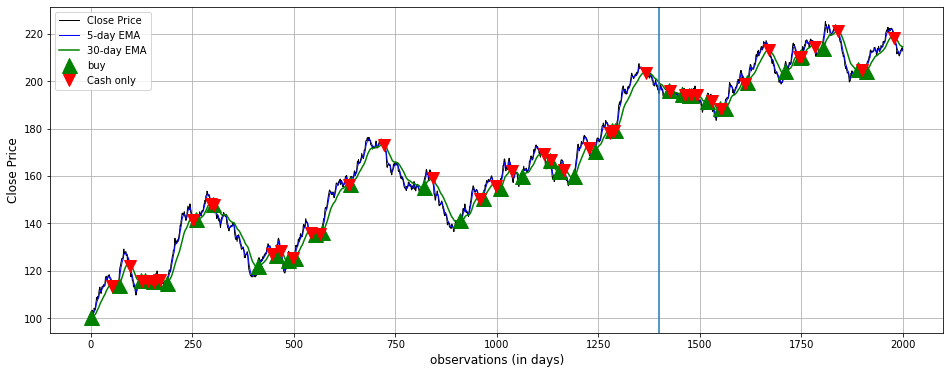

<Figure size 432x288 with 0 Axes>

In [212]:
plt.figure(figsize = (16,6))
# plot close price, short-term and long-term moving averages 
data['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price')  
data['short EMA'].plot(color = 'b', lw = 1, label = '5-day EMA') 
data['long EMA'].plot(color = 'g', lw = 1.5, label = '30-day EMA')
# plot ‘buy’ and 'hold' signals
plt.plot(data[data['Position'] == 1].index, 
         data['short EMA'][data['Position']  == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
plt.plot(data[data['Position'] == -1].index, 
          data['short EMA'][data['Position'] == -1], 
         'v', markersize = 12, color = 'r', label = 'Cash only')
plt.ylabel('Close Price', fontsize = 12 )
plt.xlabel('observations (in days)', fontsize = 12 )
plt.axvline(x=len(df_train))
#plt.title('EMA Crossover Strategy', fontsize = 15)
plt.legend()
plt.grid()
plt.show()
plt.savefig("EMA_totaltrading.png")